# Import and Download Data

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d khaleeel347/harga-rumah-seluruh-kecamatan-di-kota-bandung

!unzip harga-rumah-seluruh-kecamatan-di-kota-bandung.zip

In [ ]:
pip install category_encoders xgboost optuna

In [68]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
import optuna

# Preprocess

In [21]:
file_path = '/content/results.csv'
df = pd.read_csv(file_path)
df.head()

Rumah Premier  Rp 2,1 Miliar   Cicilan: 7 Jutaan per bulan  \
0  Rumah     NaN  Rp 4,1 Miliar  Cicilan: 15 Jutaan per bulan   
1  Rumah     NaN  Rp 3,3 Miliar  Cicilan: 12 Jutaan per bulan   
2  Rumah     NaN    Rp 580 Juta   Cicilan: 2 Jutaan per bulan   
3  Rumah     NaN  Rp 1,3 Miliar   Cicilan: 4 Jutaan per bulan   
4  Rumah     NaN  Rp 3,6 Miliar  Cicilan: 13 Jutaan per bulan   

  Rumah 2 Lantai Bagus Sertifikat Hak Milik di Maltra Residence, Bandung  \
0                    Rumah Cantik @ Andir (Sudirman)                       
1  Jual Cepat Rumah di Maleber Rajawali Bisa Untu...                       
2  Rumah minimalis 3 lantai di andir Bandung coco...                       
3  Jual Rumah Murah Bisa Dijadikan Kos”an Di Jala...                       
4  Rumah 2,5 Lantai Strategis SHM di Komplek Kert...                       

   Andir, Bandung   3  2  2.1  137 m²  170 m²  
0  Andir, Bandung   3  2    3  202 m²  300 m²  
1  Andir, Bandung   5  2    1  350 m²  258 m²  
2  Andir, Bandung   2  2    1   30 m²   80 m²  
3  Andir, Bandung  11  3    0  176 m²  176 m²  
4  Andir, Bandung   5  3    1  184 m²  234 m²

In [22]:
df.loc[-1] = df.columns
df.index = df.index + 1
df = df.sort_index()

df.columns = [
    'type',
    'status',
    'price',
    'installment',
    'house_name',
    'location',
    'bedroom_count',
    'bathroom_count',
    'carport_count',
    'land_area',
    'building_area'
]

df['bedroom_count'] = df['bedroom_count'].astype(int)
df['bathroom_count'] = df['bathroom_count'].astype(int)
df['carport_count'] = df['carport_count'].astype(float).astype(int)

df.head()

type   status          price                   installment  \
0  Rumah  Premier  Rp 2,1 Miliar   Cicilan: 7 Jutaan per bulan   
1  Rumah      NaN  Rp 4,1 Miliar  Cicilan: 15 Jutaan per bulan   
2  Rumah      NaN  Rp 3,3 Miliar  Cicilan: 12 Jutaan per bulan   
3  Rumah      NaN    Rp 580 Juta   Cicilan: 2 Jutaan per bulan   
4  Rumah      NaN  Rp 1,3 Miliar   Cicilan: 4 Jutaan per bulan   

                                          house_name        location  \
0  Rumah 2 Lantai Bagus Sertifikat Hak Milik di M...  Andir, Bandung   
1                    Rumah Cantik @ Andir (Sudirman)  Andir, Bandung   
2  Jual Cepat Rumah di Maleber Rajawali Bisa Untu...  Andir, Bandung   
3  Rumah minimalis 3 lantai di andir Bandung coco...  Andir, Bandung   
4  Jual Rumah Murah Bisa Dijadikan Kos”an Di Jala...  Andir, Bandung   

   bedroom_count  bathroom_count  carport_count land_area building_area  
0              3               2              2    137 m²        170 m²  
1              3               2              3    202 m²        300 m²  
2              5               2              1    350 m²        258 m²  
3              2               2              1     30 m²         80 m²  
4             11               3              0    176 m²        176 m²

In [23]:
df[df['house_name'].str.contains('Rumah Langka Belanda Terawat di Main Road Dipa', case=False, na=False)]

type status           price                    installment  \
4456  Rumah    NaN  Rp 79,5 Miliar  Cicilan: 295 Jutaan per bulan   
4457  Rumah    NaN  Rp 79,5 Miliar  Cicilan: 295 Jutaan per bulan   

                                             house_name          location  \
4456  Rumah Langka Belanda Terawat di Main Road Dipa...  Coblong, Bandung   
4457  Rumah Langka Belanda Terawat di Main Road Dipa...  Coblong, Bandung   

      bedroom_count  bathroom_count  carport_count land_area building_area  
4456             23              10              0   2122 m²        901 m²  
4457             23              10              0   2122 m²        901 m²

In [24]:
df[df['house_name'].str.contains('Rumah baru 3 Lantai minimalis gaya modern di c', case=False, na=False)]

type status          price                    installment  \
3569  Rumah    NaN  Rp 720 Miliar  Cicilan: 2 Miliaran per bulan   

                                             house_name         location  \
3569  Rumah baru 3 Lantai minimalis gaya modern di c...  Cibiru, Bandung   

      bedroom_count  bathroom_count  carport_count land_area building_area  
3569              3               2              1     81 m²        120 m²

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7611 entries, 0 to 7610
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   type            7611 non-null   object
 1   status          145 non-null    object
 2   price           7611 non-null   object
 3   installment     7611 non-null   object
 4   house_name      7611 non-null   object
 5   location        7611 non-null   object
 6   bedroom_count   7611 non-null   int64 
 7   bathroom_count  7611 non-null   int64 
 8   carport_count   7611 non-null   int64 
 9   land_area       7609 non-null   object
 10  building_area   7610 non-null   object
dtypes: int64(3), object(8)
memory usage: 713.5+ KB


Hampir semua baris di kolom 'status' null

In [26]:
land_area_ends_with_m2 = df['land_area'].astype(str).str.endswith(' m²')
print(f"Jumlah baris 'land_area' yang diakhiri dengan ' m²': {land_area_ends_with_m2.sum()}")

df[~land_area_ends_with_m2].head()

Jumlah baris 'land_area' yang diakhiri dengan ' m²': 7609


type status           price                   installment  \
194   Rumah    NaN  Rp 1,65 Miliar   Cicilan: 6 Jutaan per bulan   
4034  Rumah    NaN   Rp 3,7 Miliar  Cicilan: 13 Jutaan per bulan   

                              house_name          location  bedroom_count  \
194           Home industry di Cibeureum    Andir, Bandung              8   
4034  rumah tua sayap pajajaran for sale  Cicendo, Bandung              5   

      bathroom_count  carport_count land_area building_area  
194                3              0       NaN           NaN  
4034               2              3       NaN        308 m²

In [27]:
building_area_ends_with_m2 = df['building_area'].astype(str).str.endswith(' m²')
print(f"Jumlah baris 'building_area' yang diakhiri dengan ' m²': {building_area_ends_with_m2.sum()}")

df[~building_area_ends_with_m2].head()

Jumlah baris 'building_area' yang diakhiri dengan ' m²': 7610


type status           price                  installment  \
194  Rumah    NaN  Rp 1,65 Miliar  Cicilan: 6 Jutaan per bulan   

                     house_name        location  bedroom_count  \
194  Home industry di Cibeureum  Andir, Bandung              8   

     bathroom_count  carport_count land_area building_area  
194               3              0       NaN           NaN

In [28]:
df.dropna(subset=['land_area', 'building_area'], inplace=True)

Hampir semua baris di kolom status null value

In [29]:
df.isna().sum()

type                 0
status            7464
price                0
installment          0
house_name           0
location             0
bedroom_count        0
bathroom_count       0
carport_count        0
land_area            0
building_area        0
dtype: int64

Semua baris di kolom 'type' adalah rumah

In [30]:
df['type'].value_counts()

type
Rumah    7609
Name: count, dtype: int64

Drop kolom 'type' dan 'status'

In [31]:
df = df.drop(columns=['type', 'status', 'installment'])

cols = df.columns.tolist()
cols.remove('price')
cols += ['price']

df = df[cols]

Semua data di kolom price jutaan dan miliaran

In [32]:
price_ends_with_miliar = df['price'].astype(str).str.contains(' Miliar')
price_ends_with_juta = df['price'].astype(str).str.contains(' Juta')

price_not_miliar_or_juta = ~(price_ends_with_miliar | price_ends_with_juta)

print(f"Jumlah baris 'price' yang TIDAK mengandung ' Miliar' atau ' Juta': {price_not_miliar_or_juta.sum()}")

Jumlah baris 'price' yang TIDAK mengandung ' Miliar' atau ' Juta': 0


Terdapat 616 data duplikat

In [33]:
print("Jumlah duplikasi: ", df.duplicated().sum())

Jumlah duplikasi:  616


In [34]:
df[df.duplicated(keep=False)]

house_name  \
25    Rumah 2 Lantai di Rajawali Sakti Dekat Superma...   
27    Jual Cepat Rumah di Maleber Rajawali Bisa Untu...   
55    Dijual Rumah Baru Ditengah Kota Andir. Rumah S...   
56    Dijual Rumah Baru Ditengah Kota Andir. Rumah S...   
69    Rumah 2 Lantai di Rajawali Sakti Dekat Superma...   
...                                                 ...   
7586    Rumah Full Furnished Siap Huni Pasadena Bandung   
7592           Rumah Luas Dan Asri Di Komp.Dian Permai,   
7596   Rumah Lux Terawat di Taman Sakura Raya , Bandung   
7599    Rumah Full Furnished Siap Huni Pasadena Bandung   
7606   Rumah Lux Terawat di Taman Sakura Raya , Bandung   

                     location  bedroom_count  bathroom_count  carport_count  \
25             Andir, Bandung              4               1              0   
27             Andir, Bandung              5               2              3   
55             Andir, Bandung              3               2              1   
56             Andir, Bandung              3               2              1   
69             Andir, Bandung              4               1              0   
...                       ...            ...             ...            ...   
7586  Babakanciparay, Bandung              4               2              0   
7592  Babakanciparay, Bandung              3               2              2   
7596  Babakanciparay, Bandung              4               5              0   
7599  Babakanciparay, Bandung              4               2              0   
7606  Babakanciparay, Bandung              4               5              0   

     land_area building_area           price  
25       97 m²         90 m²   Rp 1,1 Miliar  
27      350 m²        258 m²   Rp 3,3 Miliar  
55       70 m²        116 m²   Rp 1,6 Miliar  
56       70 m²        116 m²   Rp 1,6 Miliar  
69       97 m²         90 m²   Rp 1,1 Miliar  
...        ...           ...             ...  
7586    113 m²        250 m²   Rp 1,7 Miliar  
7592    223 m²        100 m²  Rp 1,67 Miliar  
7596    600 m²        500 m²    Rp 11 Miliar  
7599    113 m²        250 m²   Rp 1,7 Miliar  
7606    600 m²        500 m²    Rp 11 Miliar  

[1117 rows x 8 columns]

Drop baris yang duplikat

In [35]:
df = df.drop_duplicates().reset_index(drop=True)

Sudah tidak ada data yang duplikat

In [36]:
print("Jumlah duplikasi: ", df.duplicated().sum())

Jumlah duplikasi:  0


In [37]:
df.head()

house_name        location  \
0  Rumah 2 Lantai Bagus Sertifikat Hak Milik di M...  Andir, Bandung   
1                    Rumah Cantik @ Andir (Sudirman)  Andir, Bandung   
2  Jual Cepat Rumah di Maleber Rajawali Bisa Untu...  Andir, Bandung   
3  Rumah minimalis 3 lantai di andir Bandung coco...  Andir, Bandung   
4  Jual Rumah Murah Bisa Dijadikan Kos”an Di Jala...  Andir, Bandung   

   bedroom_count  bathroom_count  carport_count land_area building_area  \
0              3               2              2    137 m²        170 m²   
1              3               2              3    202 m²        300 m²   
2              5               2              1    350 m²        258 m²   
3              2               2              1     30 m²         80 m²   
4             11               3              0    176 m²        176 m²   

           price  
0  Rp 2,1 Miliar  
1  Rp 4,1 Miliar  
2  Rp 3,3 Miliar  
3    Rp 580 Juta  
4  Rp 1,3 Miliar

Bersihin satuan di kolom 'land_area' dan 'building_area'

In [38]:
df['land_area'] = df['land_area'].str.replace(' m²', '', regex=False).str.replace(',', '').astype(float)
df['building_area'] = df['building_area'].str.replace(' m²', '', regex=False).str.replace(',', '').astype(float)

Lokasi rumah semuanya di Bandung

In [39]:
df['location'].value_counts()

location
Arcamanik, Bandung           360
Mandalajati, Bandung         351
Cicendo, Bandung             339
Andir, Bandung               333
Lengkong, Bandung            324
Buah Batu, Bandung           317
Batununggal, Bandung         316
Astanaanyar, Bandung         316
Cibiru, Bandung              302
Babakanciparay, Bandung      291
Bandung Wetan, Bandung       289
Cidadap, Bandung             288
Bojongloa Kidul, Bandung     258
Regol, Bandung               242
Bandung Kidul, Bandung       241
Antapani, Bandung            234
Rancasari, Bandung           228
Bandung Kulon, Bandung       223
Ujungberung, Bandung         219
Sumurbandung, Bandung        217
Sukasari, Bandung            204
Kiaracondong, Bandung        202
Panyileukan, Bandung         201
Sukajadi, Bandung            185
Gede Bage, Bandung           185
Coblong, Bandung             179
Cibeunying Kidul, Bandung    149
Name: count, dtype: int64

Hapus kata Bandung di kolom 'location', karena semuanya di Bandung

In [40]:
df['location'] = df['location'].str.split(',').str[0]

Bersihin kolom 'price' jadi float

In [41]:
pd.set_option('display.max_rows', None)

df['price'].value_counts()

price
Rp 2,5 Miliar     162
Rp 1,5 Miliar     143
Rp 3,5 Miliar     131
Rp 1,6 Miliar     123
Rp 1,2 Miliar     122
Rp 1,1 Miliar     121
Rp 4,5 Miliar     118
Rp 1,3 Miliar     114
Rp 2 Miliar       106
Rp 1,9 Miliar      85
Rp 1,8 Miliar      84
Rp 4 Miliar        81
Rp 5 Miliar        79
Rp 6,5 Miliar      79
Rp 3 Miliar        77
Rp 1,4 Miliar      76
Rp 5,5 Miliar      73
Rp 1,7 Miliar      73
Rp 2,2 Miliar      72
Rp 7 Miliar        71
Rp 800 Juta        71
Rp 2,3 Miliar      69
Rp 2,6 Miliar      65
Rp 1,65 Miliar     65
Rp 2,1 Miliar      65
Rp 3,2 Miliar      62
Rp 900 Juta        62
Rp 2,8 Miliar      61
Rp 750 Juta        60
Rp 2,7 Miliar      60
Rp 1,75 Miliar     60
Rp 550 Juta        58
Rp 650 Juta        56
Rp 850 Juta        56
Rp 600 Juta        54
Rp 1 Miliar        54
Rp 1,45 Miliar     54
Rp 7,5 Miliar      53
Rp 950 Juta        52
Rp 1,35 Miliar     52
Rp 1,25 Miliar     52
Rp 2,9 Miliar      51
Rp 1,55 Miliar     50
Rp 8 Miliar        49
Rp 18 Miliar       47
Rp 8,5 Miliar      45
Rp 1,95 Miliar     45
Rp 9,5 Miliar      45
Rp 10 Miliar       44
Rp 11 Miliar       42
Rp 3,9 Miliar      42
Rp 875 Juta        41
Rp 2,75 Miliar     41
Rp 2,25 Miliar     40
Rp 3,8 Miliar      40
Rp 2,85 Miliar     40
Rp 700 Juta        39
Rp 3,6 Miliar      39
Rp 6 Miliar        39
Rp 4,2 Miliar      38
Rp 2,4 Miliar      38
Rp 12 Miliar       37
Rp 1,85 Miliar     37
Rp 890 Juta        35
Rp 3,25 Miliar     31
Rp 16 Miliar       31
Rp 7,9 Miliar      29
Rp 1,15 Miliar     29
Rp 3,1 Miliar      29
Rp 3,75 Miliar     29
Rp 6,8 Miliar      28
Rp 3,95 Miliar     27
Rp 9 Miliar        26
Rp 500 Juta        26
Rp 25 Miliar       26
Rp 4,25 Miliar     25
Rp 450 Juta        25
Rp 7,8 Miliar      25
Rp 675 Juta        24
Rp 3,3 Miliar      23
Rp 13 Miliar       23
Rp 2,15 Miliar     21
Rp 3,7 Miliar      21
Rp 1,99 Miliar     21
Rp 17 Miliar       21
Rp 14 Miliar       20
Rp 3,4 Miliar      20
Rp 30 Miliar       20
Rp 525 Juta        19
Rp 4,8 Miliar      19
Rp 4,3 Miliar      19
Rp 20 Miliar       19
Rp 12,5 Miliar     18
Rp 35 Miliar       18
Rp 400 Juta        18
Rp 625 Juta        17
Rp 795 Juta        17
Rp 3,85 Miliar     16
Rp 975 Juta        16
Rp 2,35 Miliar     16
Rp 5,8 Miliar      16
Rp 670 Juta        15
Rp 22 Miliar       15
Rp 13,5 Miliar     15
Rp 4,9 Miliar      15
Rp 350 Juta        15
Rp 15 Miliar       15
Rp 644 Juta        15
Rp 2,45 Miliar     15
Rp 2,65 Miliar     15
Rp 5,2 Miliar      14
Rp 380 Juta        14
Rp 3,15 Miliar     14
Rp 19 Miliar       13
Rp 2,95 Miliar     13
Rp 6,9 Miliar      13
Rp 28 Miliar       13
Rp 23 Miliar       12
Rp 4,1 Miliar      12
Rp 10,5 Miliar     12
Rp 40 Miliar       12
Rp 8,8 Miliar      12
Rp 6,3 Miliar      12
Rp 3,65 Miliar     12
Rp 490 Juta        12
Rp 6,7 Miliar      11
Rp 999 Juta        11
Rp 532 Juta        11
Rp 610 Juta        11
Rp 2,55 Miliar     11
Rp 1,37 Miliar     11
Rp 4,75 Miliar     11
Rp 5,75 Miliar     11
Rp 1,05 Miliar     10
Rp 6,25 Miliar     10
Rp 8,25 Miliar     10
Rp 575 Juta        10
Rp 775 Juta        10
Rp 420 Juta        10
Rp 990 Juta        10
Rp 725 Juta        10
Rp 1,29 Miliar     10
Rp 690 Juta        10
Rp 32 Miliar        9
Rp 1,89 Miliar      9
Rp 3,35 Miliar      9
Rp 495 Juta         9
Rp 5,6 Miliar       9
Rp 300 Juta         9
Rp 325 Juta         9
Rp 4,7 Miliar       9
Rp 430 Juta         9
Rp 45 Miliar        9
Rp 6,75 Miliar      9
Rp 1,97 Miliar      9
Rp 680 Juta         9
Rp 760 Juta         9
Rp 5,25 Miliar      9
Rp 1,79 Miliar      9
Rp 580 Juta         8
Rp 4,6 Miliar       8
Rp 4,65 Miliar      8
Rp 895 Juta         8
Rp 42 Miliar        8
Rp 27 Miliar        8
Rp 4,99 Miliar      8
Rp 475 Juta         8
Rp 1,27 Miliar      8
Rp 925 Juta         8
Rp 825 Juta         8
Rp 830 Juta         8
Rp 1,57 Miliar      8
Rp 8,74 Miliar      8
Rp 935 Juta         8
Rp 5,3 Miliar       7
Rp 8,75 Miliar      7
Rp 18,5 Miliar      7
Rp 499 Juta         7
Rp 530 Juta         7
Rp 785 Juta         7
Rp 370 Juta         7
Rp 1,49 Mili

In [42]:
df['price_clean'] = df['price'].astype(str).str.replace("Rp", "", regex=False).str.strip()

miliar_mask = df['price_clean'].str.contains('Miliar', na=False)
df.loc[miliar_mask, 'price'] = (
    pd.to_numeric(
        df.loc[miliar_mask, 'price_clean']
        .str.replace(" Miliar", "", regex=False)
        .str.replace('.', '', regex=False)
        .str.replace(',', '.', regex=False),
        errors='coerce'
    ) * 1_000_000_000
)

juta_mask = df['price_clean'].str.contains('Juta', na=False)
df.loc[juta_mask, 'price'] = (
    pd.to_numeric(
        df.loc[juta_mask, 'price_clean']
        .str.replace(" Juta", "", regex=False)
        .str.replace('.', '', regex=False)
        .str.replace(',', '.', regex=False),
        errors='coerce'
    ) * 1_000_000
)

df.drop(columns='price_clean', inplace=True)

In [43]:
df.head()

house_name location  bedroom_count  \
0  Rumah 2 Lantai Bagus Sertifikat Hak Milik di M...    Andir              3   
1                    Rumah Cantik @ Andir (Sudirman)    Andir              3   
2  Jual Cepat Rumah di Maleber Rajawali Bisa Untu...    Andir              5   
3  Rumah minimalis 3 lantai di andir Bandung coco...    Andir              2   
4  Jual Rumah Murah Bisa Dijadikan Kos”an Di Jala...    Andir             11   

   bathroom_count  carport_count  land_area  building_area         price  
0               2              2      137.0          170.0  2100000000.0  
1               2              3      202.0          300.0  4100000000.0  
2               2              1      350.0          258.0  3300000000.0  
3               2              1       30.0           80.0   580000000.0  
4               3              0      176.0          176.0  1300000000.0

In [44]:
df.describe(include="all")

house_name   location  \
count                                                6993       6993   
unique                                               6814         27   
top     Rumah 1 lantai dekat perkantoran dan jalanan r...  Arcamanik   
freq                                                    6        360   
mean                                                  NaN        NaN   
std                                                   NaN        NaN   
min                                                   NaN        NaN   
25%                                                   NaN        NaN   
50%                                                   NaN        NaN   
75%                                                   NaN        NaN   
max                                                   NaN        NaN   

        bedroom_count  bathroom_count  carport_count     land_area  \
count     6993.000000     6993.000000    6993.000000   6993.000000   
unique            NaN             NaN            NaN           NaN   
top               NaN             NaN            NaN           NaN   
freq              NaN             NaN            NaN           NaN   
mean         4.506364        3.202774       1.395252    275.232089   
std          4.800541        4.178930       1.969502    438.553828   
min          0.000000        0.000000       0.000000      6.000000   
25%          3.000000        2.000000       0.000000    102.000000   
50%          4.000000        3.000000       1.000000    165.000000   
75%          5.000000        3.000000       2.000000    312.000000   
max         99.000000       99.000000      40.000000  11850.000000   

        building_area         price  
count    6.993000e+03  6.993000e+03  
unique            NaN  6.850000e+02  
top               NaN  2.500000e+09  
freq              NaN  1.620000e+02  
mean     6.776937e+02           NaN  
std      3.594461e+04           NaN  
min     -2.500000e+02           NaN  
25%      1.000000e+02           NaN  
50%      1.800000e+02           NaN  
75%      3.000000e+02           NaN  
max      3.006000e+06           NaN

Data yang building area nya negatif

In [45]:
df[df['building_area'] < 0]

house_name         location  \
2385  Rumah Cantik 2 lantai di Singgasana Karangkamu...  Bojongloa Kidul   

      bedroom_count  bathroom_count  carport_count  land_area  building_area  \
2385              4               3              2      200.0         -250.0   

             price  
2385  3350000000.0

Kemungkinan salah ketik, dibuat positif saja

In [46]:
df['building_area'] = df['building_area'].abs()

Cek tipe data

In [47]:
print(df.dtypes)

house_name         object
location           object
bedroom_count       int64
bathroom_count      int64
carport_count       int64
land_area         float64
building_area     float64
price              object
dtype: object


Ubah tipe data price jadi float

In [48]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [49]:
print(df.dtypes)

house_name         object
location           object
bedroom_count       int64
bathroom_count      int64
carport_count       int64
land_area         float64
building_area     float64
price             float64
dtype: object


# EDA

## Bedroom

Persebaran jumlah kamar tidur, dengan mayoritas berada pada sekitar 1 sampai 5.

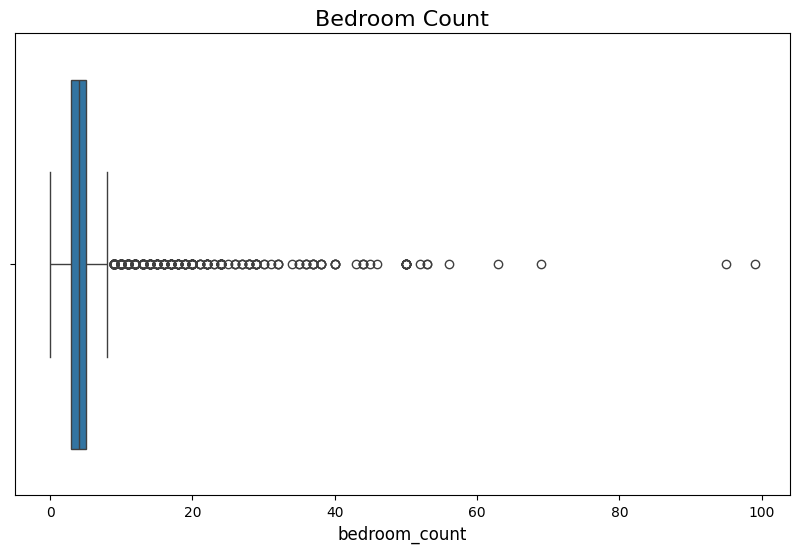

In [50]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['bedroom_count'])

plt.title('Bedroom Count', fontsize=16)
plt.xlabel('bedroom_count', fontsize=12)

plt.show()

Ada beberapa jenis properti selain rumah, seperti hotel, kos, atau ruko

In [51]:
df[df['bedroom_count'] > 50]

house_name      location  \
398   Hotel Aktif Bintang 3 Furnished Dekat Alun Alu...   Astanaanyar   
633      Dijual hotel mewah aktif strategis Astanaanyar   Astanaanyar   
2751  Rumah Kost Strategis Furnished Terisi 56 Kamar...     Buah Batu   
3454  Hotel Bagus, Mewah, Sangat Strategis di Kebon ...       Cicendo   
4044          Dijual Kostan di Jl Cisitu Lama - Bandung       Coblong   
4136  Rumah Kost Lokasi Dekat Ke Kampus Unpad di Ban...       Coblong   
4484                           Kost-Gudang Kiaracondong  Kiaracondong   
5911  Dijual Kos Premium 100 Kamar 4 Lantai Furnish ...      Sukajadi   

      bedroom_count  bathroom_count  carport_count  land_area  building_area  \
398              53              60             40     1100.0         3000.0   
633              53              60             40     1100.0         3000.0   
2751             56              56              6    10000.0         1800.0   
3454             95              95              0     2024.0         3716.0   
4044             52              35              0      500.0         1250.0   
4136             69              69             30     2000.0          850.0   
4484             63              12              1      573.0          400.0   
5911             99              99              0     2454.0         4000.0   

             price  
398   5.000000e+10  
633   5.000000e+10  
2751  2.300000e+10  
3454  3.750000e+10  
4044  1.050000e+10  
4136  2.300000e+10  
4484  7.100000e+09  
5911  4.500000e+10

Drop data yang bukan rumah

In [52]:
df = df[df['house_name'].str.contains('rumah|house|rumaah|home|cluster', case=False, na=False)]

## Bathroom

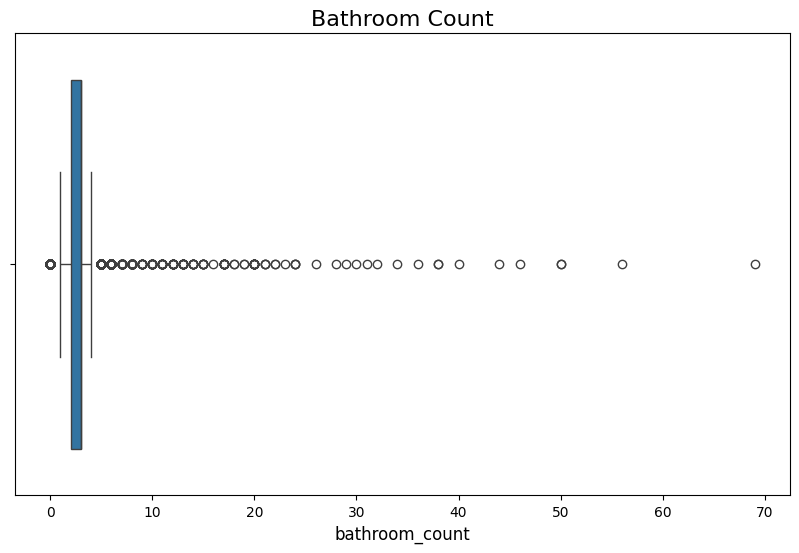

In [53]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['bathroom_count'])

plt.title('Bathroom Count', fontsize=16)
plt.xlabel('bathroom_count', fontsize=12)

plt.show()

Ada missing value di kolom 'bedroom_count', 'bathroom_count', dan 'carport_count'. Kemungkinan salah ketik atau kesalahan saat scraping

In [54]:
df[(df['bedroom_count'] == 0) & (df['bathroom_count'] == 0) & (df['carport_count'] == 0)]

house_name          location  \
24                           Rumah 2 lantai di Maleber              Andir   
58    Rumah Kawasan Ramai Cocok Untuk Usaha di Kebon...             Andir   
123   Rumah Toko Hitung Tanah Saja di Jendral Sudirm...             Andir   
157   5,6 M Nego Rumah Besar di Kompleks Dadali Raja...             Andir   
182         Town house bagus cluster Paledang cibeureum             Andir   
276   Rumah 2 Lantai pusat kota dekat bandara husen ...             Andir   
285   Rumah di daerah sayap rajawali hitung tanah sa...             Andir   
508        Jual Rumah Hitung Tanah Saja. Astana Anyar.        Astanaanyar   
538      For Sale, Rumah cantik super nyaman di Bandung       Astanaanyar   
581   1,6 M Nego Rumah Tengah Kota Sayap Astana Anya...       Astanaanyar   
614   Jual Cepat Rumah Di Sayap Jalan Pagarsih Bandu...       Astanaanyar   
680   Rumah Indent Areal Sindangsari Antapani Kota B...          Antapani   
768   Murah Dijual Rumah lt144/270 hrg1,250 di Clust...          Antapani   
832                  Rumah Bagus Shm, Antapani, Bandung          Antapani   
896   Dijual cepat rumah lt176/140 hrg1m An dibawah ...         Arcamanik   
996   Jual Tanah bonus rumah lt287/170 hrg1,2 Cisara...         Arcamanik   
1014  dijual cepat rumah siap huni lt176/120 harga1,...         Arcamanik   
1107  Dijual murah rumah lt180/120 hrg1,1 d cluster ...         Arcamanik   
1159  Di jual murah lt135/60 hrg700 nego rumah dekat...         Arcamanik   
1252                Rumah mungil siap huni Taman Sakura     Bandung Kidul   
1349                                        Rumah murah     Bandung Kidul   
1376                    Rumah mewah di Batunuggal Indah     Bandung Kidul   
1442                      Rmh mewah dlm.Komp Perumahan      Bandung Kidul   
1545  Dijual Rumah 2 Lantai Lokasi Cisaranten Kulon ...     Bandung Kulon   
1559  Dijual Rumah Mainroad Jalan Wastu Kencana Band...     Bandung Kulon   
1624  Jual Cepat Rumah Bisa Untuk Gudang di Holis Re...     Bandung Kulon   
1655     Dijual rumah semi furnish di Taman Holis Indah     Bandung Kulon   
1684  Rumah Sayap Sudirman Harga Kurang Dari 1 M Mas...     Bandung Kulon   
1708  RUMAH BISA USAHA DI WASTUKENCANA,  HARGA DIBAW...     Bandung Wetan   
1980             Dijual Rumah Tua Terawat di Sayap Riau     Bandung Wetan   
1985                               RUMAH SHM SAYAP RIAU     Bandung Wetan   
1994  Rumah Hitung Tanah di Bengawan Bandung, Sangat...     Bandung Wetan   
2043                    Dijual Rumah Bagus Batununggal        Batununggal   
2217  rumah bagus lux terawat di mainroad batunungga...       Batununggal   
2242          Dijual Rumah di Batununggal Indah Cluster       Batununggal   
2624                      Dijual Rumah Kerang Buah Batu         Buah Batu   
2706  Dijual rumah penginapan lt200/250 hrg3M di Tur...         Buah Batu   
2813  Jual Rumah nyaman dalam Cluster lokasi strateg...         Buah Batu   
2894   Dijual Rumah Pasirlayung View 180° Kota Bandung   Cibeunying Kidul   
2942            Jual Rumah Strategis Cibeunying Bandung  Cibeunying Kidul   
2992  Rumah Minimalis Cibiru Siap Huni Dekat Upi Cibiru  Cibeunying Kidul   
3147  Dijual rumah harga350jt siap huni di Griya Pos...            Cibiru   
3182  Rumah Baru Cluster Pesona Cipadung Kodya Bandu...            Cibiru   
3259        Rumah di Soekarno-hatta Cibiru Bandung SHM             Cibiru   
3324  Rumah Murah Siap Huni ermata Biru 300 Jutaan J...            Cibiru   
3364        Rumah hitung tanah di Pasirkaliki Main road           Cicendo   
3589     Rumah 3 Lantai di Lynn Parc Landmark Residence           Cicendo   
3641  Rumah 3 Lantai Nyaman Jarang Ada Unfurnished S...           Cicendo   
3652  Dijual Rumah Mewah Taman Millenium Pajajaran S...           Cicendo   
3718                    Rumah bagus 2 lantai tanah luas           Cidadap   
3738           Rumah di Ciumbuleuit dekat Unpar bandung           Cidadap   
3858  RUMAH VILLA Jl. HEGARMANAH\r\nDESIG

Drop baris yang bedroom_count, bathroom_count, dan carport_count nya 0

In [55]:
df = df[~((df['bedroom_count'] == 0) & (df['bathroom_count'] == 0) & (df['carport_count'] == 0))]

Gak munkin rumah gapunya bedroom atau bathroom

In [56]:
df[(df['bedroom_count'] == 0) | (df['bathroom_count'] == 0)]

house_name          location  \
105                               Rumah siap huni elang             Andir   
375              Dijual Rumah Di Komplek Kurdi Bandung        Astanaanyar   
406           Jual rumah hitung tanah sayap cibadak bdg       Astanaanyar   
620     Dijual Rumah Mainroad Jl Pasirkoja Kota Bandung       Astanaanyar   
638             Jual Rumah Siap Huni Lok. Sayap Cibadak       Astanaanyar   
643                       Rumah / ruang usaha pasirkoja       Astanaanyar   
677   Dijual mendesak rumah antapani dalam cluster h...          Antapani   
855                    Rumah 2 Lantai Baru di Antapani           Antapani   
1073  Rumah Murah Di Bawah NJOP Di Arcamanik Endah D...         Arcamanik   
1101  @Rumah Murah Pake Bata Merah dekat Stt Telkom ...         Arcamanik   
1154  Dijual Rumah Baru Di Permata Elok Cisaranten B...         Arcamanik   
1155    Dijual Rumah Hunian Baru Di Cisaranten Bandung          Arcamanik   
1157  Dijual Rumah Minimalis Di Cisaranten Kulon Ban...         Arcamanik   
1736  Dijual Rumah Cantik Modern Furnish Di Cihapit ...     Bandung Wetan   
1745           Rumah Dijual Jalan Riau Bandung Mainroad     Bandung Wetan   
1781                                Rumah di Sayap Riau     Bandung Wetan   
1970  Rumah Hitung Tanah di Jalan Flores Sayap Riau ...     Bandung Wetan   
1977                        Rumah Kost Sayap Supratman      Bandung Wetan   
2151  Rumah Mewah Murah Siap Huni Lokasi Favorite Di...       Batununggal   
2286       JUAL NGEBUT RUMAH 2 LANTAI BATUNUNGGAL INDAH       Batununggal   
2343  Rumah Dijual Singgasana Pradana Bandung Siap Huni   Bojongloa Kidul   
2402  Rumah Dijual Singgasana Pradana Bandung Baru M...   Bojongloa Kidul   
2413  Rumah Dijual Leuwisari Bandung Baru Minimalis ...   Bojongloa Kidul   
2415    Rumah Dijual Tengah Kota Bandung Baru Minimalis   Bojongloa Kidul   
2416  Rumah Dijual Singgasana Pradana Bandung Baru M...   Bojongloa Kidul   
2417       Rumah Dijual Singgasana Pradana Bandung Baru   Bojongloa Kidul   
2418  Rumah Dijial Leuwisari Bandung Baru Minimalis ...   Bojongloa Kidul   
2420     Rumah Dijual Pusat Kota Bandung Baru Minimalis   Bojongloa Kidul   
2423             Dijual Rumah Terusan Cibaduyut Bandung   Bojongloa Kidul   
2429  Rumah Dijual Singgasana Pradana Bandung Cantik...   Bojongloa Kidul   
2493  Rumah Dijual Singgasana Pradana Bandung Siap Huni   Bojongloa Kidul   
2504   Rumah Baru Dijual Singgasana Pradana Bandung Lux   Bojongloa Kidul   
2538  Rumah Dijual/Disewakam Singgasana Pradana Bandung   Bojongloa Kidul   
2540  Rumah Dijual/Disewakan Singgasana Pradana Bandung   Bojongloa Kidul   
2543   Rumah Baru Unfurnished SHM - Sertifikat Hak M...   Bojongloa Kidul   
2871  JUAL RUMAH MURAH DEKAT STT TELKOM DAN TOL BUAH...         Buah Batu   
3026  Rumah Dijual Cikutra Bojong Koneng Bandung 3 L...  Cibeunying Kidul   
3072          Dijual Rumah Di Cibiru Residence Bandung             Cibiru   
3075   DIJUAL RUMAH MURAH ON PROGRESS,LOK. CIBIRU WETAN            Cibiru   
3152  Rumah Murah Untuk Dibangun Kost an Dekat Uin S...            Cibiru   
3387  Dijual Rumah Bagus Full Furnish Di Maple Townh...           Cicendo   
3394  Rumah Disewakan Sayap Paskal Bandung Good Loca...           Cicendo   
3437                     Rumah siap huni saya pajajaran           Cicendo   
3448              Dijual Rumah di Jl. Baladewa, Bandung           Cicendo   
3472         RUMAH SIAP HUNI LINGKUNGAN ASRI DAN NYAMAN           Cicendo   
3473  Dijual Rumah Bagus Full Furnish Di Maple Townh...           Cicendo   
3488  Dijual Rumah Lokasi Sht Strategis di Dr. Cipto...           Cicendo   
3538    Rumah Dijual Tengah Kota Bandung Baru Siap Huni           Cicendo   
3545               Rumah 2 Lantai Dekat Stasiun Bandung           Cicendo   
3608        Rumah Dijual/Disewakan Sayap Paskal Bandung           Cicendo   
3768  Rumah Dijual Cipaku Indah Bandung Mewah Siap Huni           Cidadap   
3815        Rumah Dijual Cipaku Indah Ban

Drop baris data yang bedroom_count atau bathroom_count == 0

In [57]:
df = df[(df['bedroom_count'] != 0) & (df['bathroom_count'] != 0)]

## Carport

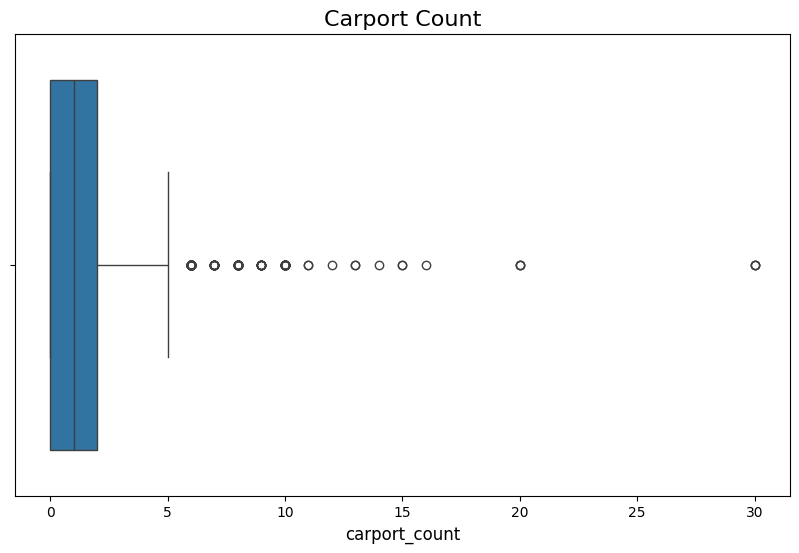

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['carport_count'])

plt.title('Carport Count', fontsize=16)
plt.xlabel('carport_count', fontsize=12)

plt.show()

Carport yang lebih dari 5

In [59]:
df[df['carport_count'] > 5]

house_name          location  \
12                  Dijual Rumah Di Tengah Kota Bandung             Andir   
15    Rumah Strategis di Komplek Dadali Bandung Dkt ...             Andir   
29    Jual Rumah Luas Dan Strategis Mainroad Rajawal...             Andir   
107   Jual Cepat Rumah Megah di Andir Tengah Kota Ba...             Andir   
117   Rumah Usah Lux Home Industri Rajawali Timur Ju...             Andir   
188                    Rumah Cantik Asri di Tengah Kota             Andir   
226         Jual Cepat Rumah Harga Murah Area Komersil              Andir   
228   Dijual Rumah Tinggal Rajawali Timur Main Road ...             Andir   
378   Jual rumah kost pusat kota di Astana anyar ban...       Astanaanyar   
400   Dijual rumah belanda lokasi strategis Astanaanyar       Astanaanyar   
431   Rumah Nyaman dan Asri di Kurdi Barat Astanaany...       Astanaanyar   
467   Dijual Rumah 2 Lantai Plus Gudang di Mainroad ...       Astanaanyar   
550   Rumah Lux di Kurdi Moh Toha Bandung ada Kolam ...       Astanaanyar   
580   Jual Rumah dan Tempat usaha lokasi pusat kota ...       Astanaanyar   
622   rumah mewah 2 lantai siap huni dan terawat di ...       Astanaanyar   
630   Rumah 3 Lantai Bagus Semi Furnished SHM di Ast...       Astanaanyar   
700   Exclusive Rumah Siap Di Tempati Lokasi Primado...          Antapani   
850      Dijual rumah + tempat usaha diAntapani Bandung          Antapani   
1096  Jual Cepat Rumah Turun Harga di Komplek Arcama...         Arcamanik   
1136  Rumah kosan aktif di cisaranten dekat sekolah ...         Arcamanik   
1244  JUAL RUMAH 2 LANTAI di Komplek Jakapurwa Kujan...     Bandung Kidul   
1247  Jual Cepat Rumah Murah SHM Lingungan Nyaman di...     Bandung Kidul   
1281                                        Rumah besar     Bandung Kidul   
1350  Rumah Strategis Di Sayap Batununggal Bandung D...     Bandung Kidul   
1352  Rumah Dijual 2 Lantai Mewah Luas Area Bandung ...     Bandung Kidul   
1404  Rumah Baru di Pasteur Cluster Modern 4KM Borma...     Bandung Kidul   
1430  Rumah Mewah Pusat Kota di Batu Indah Raya, Ter...     Bandung Kidul   
1433  Rumah Besar Luas di Komplek Jakapurwa Bandung ...     Bandung Kidul   
1533                      Rumah Area Lembah Pakar Timur     Bandung Kulon   
1652  Rumah Dan Pabrik Kecap Sangat Luas Terawat di ...     Bandung Kulon   
1727  Dijual Rumah Lokasi Strategis di Sayap Riau De...     Bandung Wetan   
1735  Rumah Dijual di Sayap Dago Dekat Purnawarman B...     Bandung Wetan   
1748  Dijual Rumah Terawat Bonus Ruang Usaha sudah T...     Bandung Wetan   
1762  Dijual Rumah 2 Lantai Heritage Garasi Luas Are...     Bandung Wetan   
1784    Rumah Main Road Purnawarman Bandung, Sayap Dago     Bandung Wetan   
1786        Dijual Rumah di Mainroad Dipenogoro Bandung     Bandung Wetan   
1824      Rumah di Kawasan Elit Sayap Dago Kota Bandung     Bandung Wetan   
1838   Rumah Dekat Gedung Sate Bandung Sayap Diponegoro     Bandung Wetan   
1858   Di  Rumah Hoek 13 Kamar Di Jl. Cisangkuy Bandung     Bandung Wetan   
1887  Rumah luas dan nyaman semi furnished di sayap ...     Bandung Wetan   
1920  Di jual rumah heritage kawasan komersial lokas...     Bandung Wetan   
1926  Dijual Rumah Lokasi Maniroad Jalan Supratman B...     Bandung Wetan   
1929                   Dijual Rumah Sayap Dago, Bandung     Bandung Wetan   
1944         Rumah Lama Terawat Hitung Tanah Sayap Dago     Bandung Wetan   
1959           Rumah Luas Di Daerah Taman Sari, Bandung     Bandung Wetan   
1960  Rumah classic cocok untuk usaha kuliner, distr...     Bandung Wetan   
1967  Jual Dan Sewa Rumah Cafe Jl Riau Mainroad Band...     Bandung Wetan   
1995  Dijual Harga Murah, Rumah di Sayap Riau. Herit...     Bandung Wetan   
2085  Rumah Strategis Untuk Kantor Dll di Mainroad J...       Batununggal   
2121  Rumah Bagus Mewah 2 Lantai Komplek Batununggal...       Batununggal   
2150  RUMAH / GUDANG  BATUNUNGGAL SOEKARNO HATTA BAN...       Batununggal   
2256  Rumah Super Lux Di Batununggal Elok

Asumsi 15m² per mobil, carport_area_ratio > 0.5 artinya lebih dari 50% lahan dipakai untuk carport

In [60]:
df['carport_area_est'] = df['carport_count'] * 15
df['carport_area_ratio'] = df['carport_area_est'] / df['land_area']

df[df['carport_area_ratio'] > 0.5]

house_name          location  \
73    Rumah Hunian Pusat Kota Bandung Murah Andir To...             Andir   
378   Jual rumah kost pusat kota di Astana anyar ban...       Astanaanyar   
1136  Rumah kosan aktif di cisaranten dekat sekolah ...         Arcamanik   
1350  Rumah Strategis Di Sayap Batununggal Bandung D...     Bandung Kidul   
1404  Rumah Baru di Pasteur Cluster Modern 4KM Borma...     Bandung Kidul   
1512  Dijual rumah di komplek istana Sudirman, lingk...     Bandung Kulon   
1658  Rumah Cantik Terawat di Cijerah 2 Lantai siap ...     Bandung Kulon   
2283  Dijual Cepat Rumah SHM di Komplek Batununggal ...       Batununggal   
2802  Rumah Nyaman Strategis Siap Huni di Margahayu ...         Buah Batu   
2991  Rumahbesar Bagus SHM Murah Strategis di Cibeun...  Cibeunying Kidul   
3066  Jual Murah Rumah Kost di Cibiru Hilir Kota Ban...            Cibiru   
3671  Rumah nyaman di cluster pasteur Bonus Kolam Re...           Cicendo   
4063    Dijual rumah Kost aktif area Dipatiukur Bandung           Coblong   
4191  Jual Rumah Bagusnya Bikin Melongo Sangat Siap ...         Gede Bage   
4446          Dijual Rumah Kost di Kiaracondong Bandung      Kiaracondong   
4543   Rumah Bagus Unfurnished SHM di Lengkong, Bandung          Lengkong   

      bedroom_count  bathroom_count  carport_count  land_area  building_area  \
73                3               2              2       49.0           72.0   
378              24               8             15      233.0          326.0   
1136             13               4             11      276.0          530.0   
1350              4               3             10      140.0          170.0   
1404             12               3             10      104.0          125.0   
1512              2               2              2       53.0           58.0   
1658              4               2              4      100.0          200.0   
2283              3               3             10      180.0          150.0   
2802             12              13              6      125.0          440.0   
2991              4               3             13      136.0          200.0   
3066             13              13              4      110.0          160.0   
3671              3               2             10      150.0          100.0   
4063             12              12             10      223.0          320.0   
4191              3               3             10      144.0          157.0   
4446              8               8              4       86.0          180.0   
4543              5               6             10      288.0          400.0   

             price  carport_area_est  carport_area_ratio  
73    1.400000e+09                30            0.612245  
378   2.800000e+09               225            0.965665  
1136  3.250000e+09               165            0.597826  
1350  2.800000e+09               150            1.071429  
1404  1.990000e+09               150            1.442308  
1512  1.100000e+09                30            0.566038  
1658  2.100000e+09                60            0.600000  
2283  2.600000e+09               150            0.833333  
2802  2.780000e+09                90            0.720000  
2991  1.100000e+09               195            1.433824  
3066  1.650000e+09                60            0.545455  
3671  2.220000e+09               150            1.000000  
4063  3.500000e+09               150            0.672646  
4191  2.950000e+09               150            1.041667  
4446  1.250000e+09                60            0.697674  
4543  6.800000e+09               150            0.520833

Drop baris data yang carport_area_ratio lebih dari 0.5

In [61]:
df = df[df['carport_area_ratio'] <= 0.5].drop(columns=['carport_area_ratio', 'carport_area_est'])

## Land Area

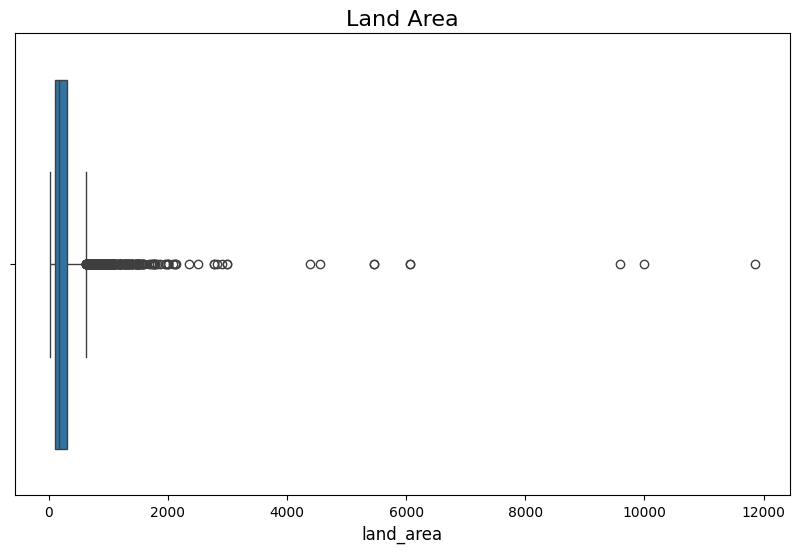

In [62]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['land_area'])

plt.title('Land Area', fontsize=16)
plt.xlabel('land_area', fontsize=12)

plt.show()

## Building Area

Ada 1 outlier yang sangat tidak masuk akal

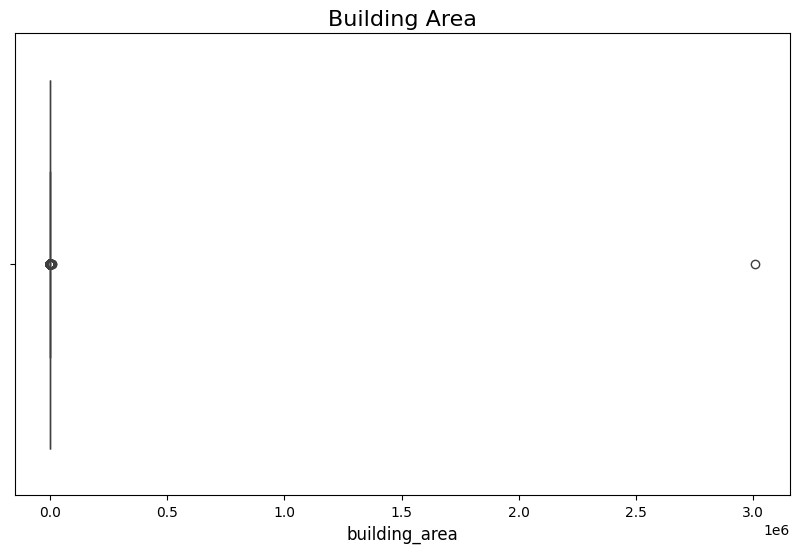

In [63]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['building_area'])

plt.title('Building Area', fontsize=16)
plt.xlabel('building_area', fontsize=12)

plt.show()

In [64]:
df[df['building_area'] > 3000000]

house_name        location  \
6753  Rumah 2 Lantai Furnished di Babakanciparay, Ba...  Babakanciparay   

      bedroom_count  bathroom_count  carport_count  land_area  building_area  \
6753              5               4              1      180.0      3006000.0   

             price  
6753  3.600000e+09

Drop saja

In [65]:
df = df[df['building_area'] <= 3000000]

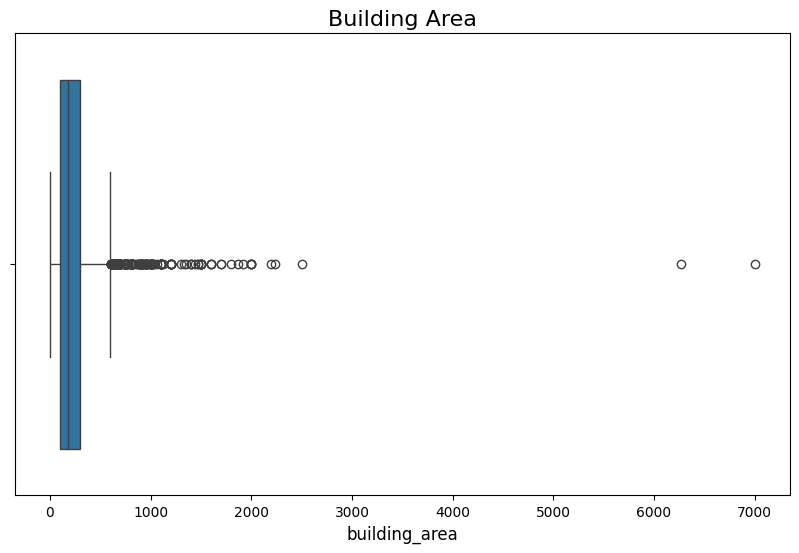

In [70]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['building_area'])

plt.title('Building Area', fontsize=16)
plt.xlabel('building_area', fontsize=12)

plt.show()



>  Tidak wajar, jarang rumah bertingkat sampai 4x luas tanah



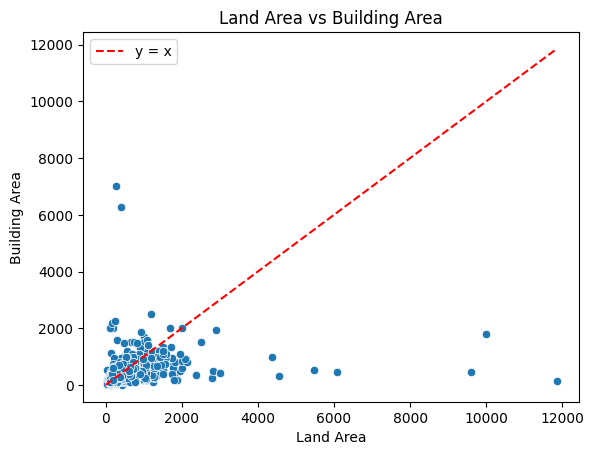

In [71]:
sns.scatterplot(data=df, x='land_area', y='building_area')

max_val = max(df['land_area'].max(), df['building_area'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y = x')

plt.title('Land Area vs Building Area')
plt.xlabel('Land Area')
plt.ylabel('Building Area')
plt.legend()
plt.show()

Building Land Ratio lebih dari 3 masih umum pada ruko, kos-kosan bertingkat, atau rumah di kavling sempit yang dibangun vertikal.

In [72]:
df['building_land_ratio'] = df['building_area'] / df['land_area']

df[df['building_land_ratio'] > 3]

house_name        location  \
87    Rumah cantik terawat di Andir town house kota ...           Andir   
343   Rumah Tengah Kota Astana anyar Dijual Cepat Murah     Astanaanyar   
493   Rumah Minimalis Tengah Kota di Sayap Otista Ba...     Astanaanyar   
573   Jual Cepat Bu Nego Rumah Masuk Mobil 4 Lantai ...     Astanaanyar   
588   Dijual Cepat Rumah 3 Lantai Siap Huni Sayap Jl...     Astanaanyar   
1077  Rumah Mainroad Arcamanik 4 Lantai 3 Kamar Tidu...       Arcamanik   
1098  Jual Cepat Rumah Turun Harga Di Komplek Jalan ...       Arcamanik   
1529   Dijual Rumah di Jend Sudirman 4 Lantai Siap Huni   Bandung Kulon   
1676  Rumah Kost Kosan 4 Lantai di Bandung Kulon Ban...   Bandung Kulon   
1759  Dijual cepat Rumah sayap Ahmad Yani, lokasi de...   Bandung Wetan   
3189  Rumah Hoek Nyaman 2 Lantai Bumi Panyileukan Ci...          Cibiru   
3444  HOT DEAL SALE!! Rumah Kost Baru Bagus 3 Lantai...         Cicendo   
3595  Dijual Rumah Kantor 3 Lantai Abdulrahman Saleh...         Cicendo   
3604  Rumah Asri Siap Huni di Komplek Mega Raya Bandung         Cicendo   
4253   Rumah Baru Minimalis 2 Lantai Gede Bage, Bandung       Gede Bage   
4654  Rumah Termurah Super Strategis di Jl.lodaya Ba...        Lengkong   
4907       Rumah Dijual 2 Lantai di Pasir Impun Bandung     Mandalajati   
5846                    Di Jual Rumah Lux Di Jl Kembar            Regol   
5903  Rumah Setraduta Bagus Unik Di Setraduta, Sukajadi        Sukajadi   
5985        Rumah kost 3 lantai dekat maranatha, polban        Sukajadi   
6002           Dijual Rumah/kos-kosan 6 Kamar Dekat PVJ        Sukajadi   
6128                Jual Rumah Mewah Setramurni Bandung        Sukasari   
6424  Rumah Dan Ruko Sayap Alun Alun Asia Afrika Ban...    Sumurbandung   
6757  Jual Rumah Siap Huni Taman Luas di Cibolerang ...  Babakanciparay   
6898  Jual cepat, Rumah nyaman di Sayap Pagarasih, B...  Babakanciparay   

      bedroom_count  bathroom_count  carport_count  land_area  building_area  \
87                2               2              1       39.0          525.0   
343               3               2              0       65.0          225.0   
493               4               2              1       59.0          200.0   
573               3               2              1       54.0          200.0   
588               3               2              1       54.0          180.0   
1077              4               3              2      114.0          400.0   
1098              3               3              1      200.0         2000.0   
1529              3               3              1      104.0          325.0   
1676             12               5              1       90.0          350.0   
1759             11               3              2      390.0         6265.0   
3189              5               3              2      112.0         2000.0   
3444             32              32              0      149.0          497.0   
3595              5               3              7      210.0          650.0   
3604              3               2              2      300.0         1600.0   
4253              4               2              0      127.0         1126.0   
4654              9               7              3      488.0         1470.0   
4907              4               2              1      175.0         2200.0   
5846              6               5              1      207.0          948.0   
5903              3               2              0       76.0          250.0   
5985             22               6              1       87.0          280.0   
6002              6               4              0       42.0          140.0   
6128              4               4              2      194.0          750.0   
6424              4               3              0      282.0         7000.0   
6757              3               2              1      234.0         2240.0   
6898              3               2              0       54.0          180.0   

             

Drop yang lebih dari 4

In [73]:
df = df[df['building_land_ratio'] <= 4]

Drop kolom Building Land Ratio

In [74]:
df = df.drop(columns=['building_land_ratio'])

## Price

In [75]:
df.head()

house_name location  bedroom_count  \
0  Rumah 2 Lantai Bagus Sertifikat Hak Milik di M...    Andir              3   
1                    Rumah Cantik @ Andir (Sudirman)    Andir              3   
2  Jual Cepat Rumah di Maleber Rajawali Bisa Untu...    Andir              5   
3  Rumah minimalis 3 lantai di andir Bandung coco...    Andir              2   
4  Jual Rumah Murah Bisa Dijadikan Kos”an Di Jala...    Andir             11   

   bathroom_count  carport_count  land_area  building_area         price  
0               2              2      137.0          170.0  2.100000e+09  
1               2              3      202.0          300.0  4.100000e+09  
2               2              1      350.0          258.0  3.300000e+09  
3               2              1       30.0           80.0  5.800000e+08  
4               3              0      176.0          176.0  1.300000e+09

Ada yang harganya sampe 735 miliar

In [76]:
pd.reset_option('display.max_rows')

df['price'].value_counts().sort_index(ascending=False)

price
7.350000e+11    1
7.200000e+11    1
2.250000e+11    2
1.260000e+11    1
1.050000e+11    1
               ..
7.500000e+07    1
4.500000e+07    2
4.000000e+07    1
2.350000e+07    1
2.200000e+07    2
Name: count, Length: 651, dtype: int64

Perkiraan rumah termahal di Indonesia bernilai sekitar Rp 500 miliar, padahal luas tanah dan luas bangunannya kecil

In [77]:
df[df['price'] > 500000000000].sort_values(by='price', ascending=False)

house_name       location  \
1456  Dijual Rumah Baru Minimalis Industrial di Kopo...  Bandung Kidul   
3218  Rumah baru 3 Lantai minimalis gaya modern di c...         Cibiru   

      bedroom_count  bathroom_count  carport_count  land_area  building_area  \
1456              2               2              1       66.0           56.0   
3218              3               2              1       81.0          120.0   

             price  
1456  7.350000e+11  
3218  7.200000e+11



> Rasio dari fitur dengan price, untuk cek apakah harga wajar dibanding ukuran atau fasilitas

> Batas wajar tergantung kota dan kondisi. Kita pakai estimasi mewah tapi masuk akal (IDR):

* price/land_area	50 juta per m² (sangat premium kota besar)
* price/building_area	100 juta per m² (fully furnished luxury)
* price/bedroom	≤ 10 miliar per kamar (super high-end)
* price/bathroom	≤ 10 miliar juga


In [78]:
for i in range(10):
    df['price_per_land_area'] = df['price'] / df['land_area']
    df['price_per_building_area'] = df['price'] / df['building_area']
    df['price_per_bedroom'] = df['price'] / df['bedroom_count'].replace(0, np.nan)
    df['price_per_bathroom'] = df['price'] / df['bathroom_count'].replace(0, np.nan)

    mask_wajar = (
        (df['price_per_land_area'] <= 50_000_000) &
        (df['price_per_building_area'] <= 100_000_000) &
        (df['price_per_bedroom'] <= 10_000_000_000) &
        (df['price_per_bathroom'] <= 10_000_000_000)
    )

    n_tidak_wajar = (~mask_wajar).sum()
    print(f"Iterasi {i+1}: {n_tidak_wajar} baris tidak wajar")

    if mask_wajar.all():
        print("Semua baris sudah wajar.")
        break

    df.loc[~mask_wajar, 'price'] *= 1e-1

df.drop(columns=[
    'price_per_land_area',
    'price_per_building_area',
    'price_per_bedroom',
    'price_per_bathroom'
], inplace=True)

Iterasi 1: 141 baris tidak wajar
Iterasi 2: 4 baris tidak wajar
Iterasi 3: 2 baris tidak wajar
Iterasi 4: 0 baris tidak wajar
Semua baris sudah wajar.


In [79]:
df[df['price'] > 50000000000].sort_values(by='price', ascending=False)

house_name location  \
4037  Rumah Langka Belanda Terawat di Main Road Dipa...  Coblong   
3388  Jual Rumah Jl Pasirkaliki 2 Arah , Tengah Kota...  Cicendo   

      bedroom_count  bathroom_count  carport_count  land_area  building_area  \
4037             23              10              0     2122.0          901.0   
3388             10              11             10     1561.0         1200.0   

             price  
4037  7.950000e+10  
3388  6.200000e+10

In [80]:
df['price'].value_counts().sort_index(ascending=False)

price
7.950000e+10    1
6.200000e+10    1
5.000000e+10    1
4.600000e+10    1
4.200000e+10    1
               ..
4.500000e+07    2
4.000000e+07    1
3.250000e+07    1
2.350000e+07    1
2.200000e+07    2
Name: count, Length: 632, dtype: int64

harga tertinggi 79.5 miliar

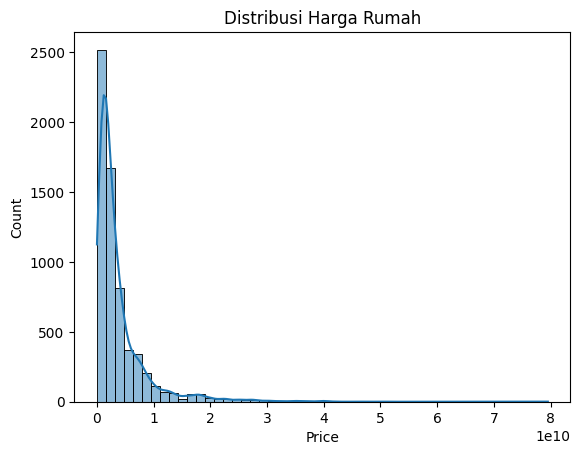

In [81]:
sns.histplot(df['price'], kde=True, bins=50)
plt.title('Distribusi Harga Rumah')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

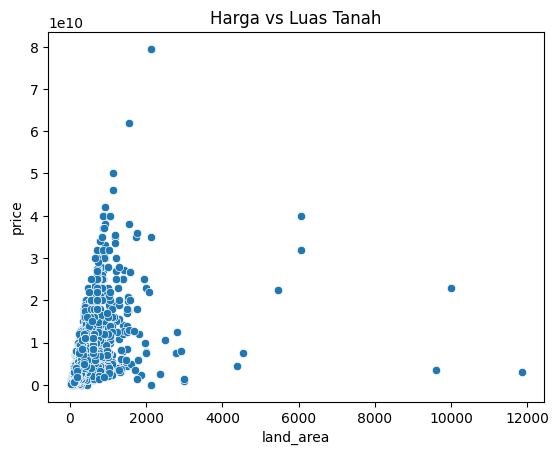

In [82]:
sns.scatterplot(data=df, x='land_area', y='price')
plt.title('Harga vs Luas Tanah')
plt.show()

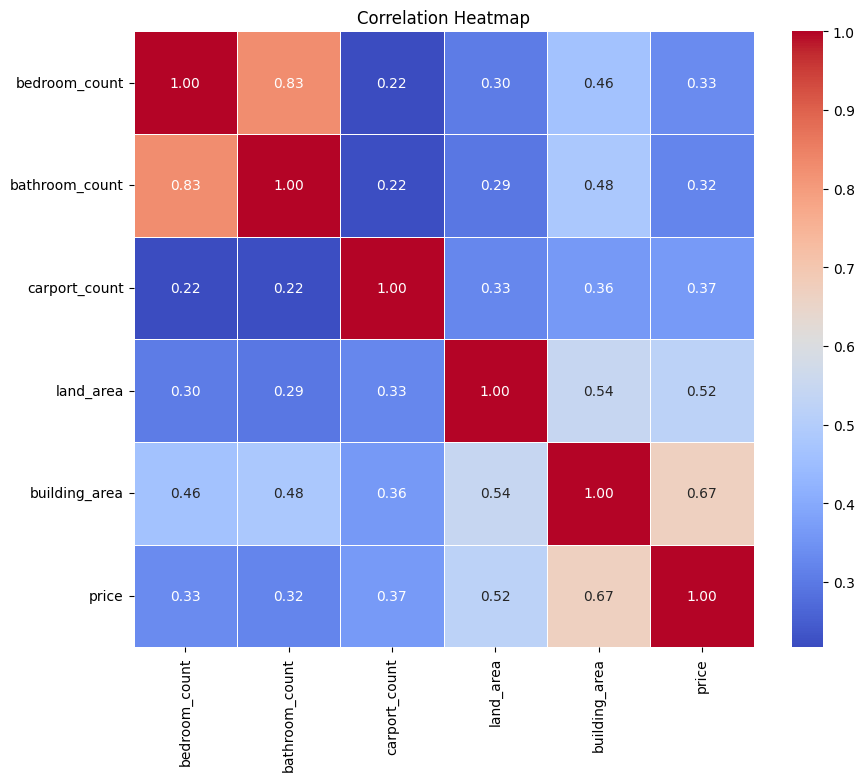

In [83]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Encoding, Split Train Test

## Location

In [84]:
df['location'].value_counts()

location
Arcamanik           337
Mandalajati         323
Andir               313
Cicendo             305
Batununggal         305
Buah Batu           291
Astanaanyar         289
Lengkong            289
Cibiru              277
Babakanciparay      274
Cidadap             262
Bandung Wetan       261
Bojongloa Kidul     237
Regol               232
Bandung Kidul       224
Antapani            222
Rancasari           212
Bandung Kulon       210
Ujungberung         200
Sumurbandung        198
Sukasari            194
Panyileukan         193
Gede Bage           177
Sukajadi            172
Kiaracondong        172
Coblong             144
Cibeunying Kidul    138
Name: count, dtype: int64

Split sebelum encode

In [85]:
df.head()

house_name location  bedroom_count  \
0  Rumah 2 Lantai Bagus Sertifikat Hak Milik di M...    Andir              3   
1                    Rumah Cantik @ Andir (Sudirman)    Andir              3   
2  Jual Cepat Rumah di Maleber Rajawali Bisa Untu...    Andir              5   
3  Rumah minimalis 3 lantai di andir Bandung coco...    Andir              2   
4  Jual Rumah Murah Bisa Dijadikan Kos”an Di Jala...    Andir             11   

   bathroom_count  carport_count  land_area  building_area         price  
0               2              2      137.0          170.0  2.100000e+09  
1               2              3      202.0          300.0  4.100000e+09  
2               2              1      350.0          258.0  3.300000e+09  
3               2              1       30.0           80.0  5.800000e+08  
4               3              0      176.0          176.0  1.300000e+09

In [86]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {len(X_train)} ({len(X_train)/len(df)*100:.2f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(df)*100:.2f}%)")

target_encoder = ce.TargetEncoder(cols=['location'])
X_train['location_encoded'] = target_encoder.fit_transform(X_train['location'], y_train)
X_test['location_encoded'] = target_encoder.transform(X_test['location'])

X_train = X_train.drop(['house_name', 'location'], axis=1)
X_test = X_test.drop(['house_name', 'location'], axis=1)

Train size: 5160 (79.99%)
Test size: 1291 (20.01%)


In [87]:
X_train.head()

bedroom_count  bathroom_count  carport_count  land_area  building_area  \
4839              4               2              0      183.0          140.0   
6117              3               2              1      302.0          150.0   
5326              3               2              1      100.0           90.0   
6841              2               3              0      180.0          135.0   
161               3               2              1      200.0          150.0   

      location_encoded  
4839      5.153604e+09  
6117      5.806580e+09  
5326      1.139917e+09  
6841      3.259817e+09  
161       3.234101e+09

# Training

In [88]:
print(f"Train size: {len(X_train)} ({len(X_train)/len(df)*100:.2f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(df)*100:.2f}%)")

Train size: 5160 (79.99%)
Test size: 1291 (20.01%)


K-Fold Cross Validation

In [89]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def get_cv_scores(model, X, y, cv):
    mae_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error'))
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    return mae_scores.mean(), rmse_scores.mean(), r2_scores.mean()

Scaled dataset

In [90]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

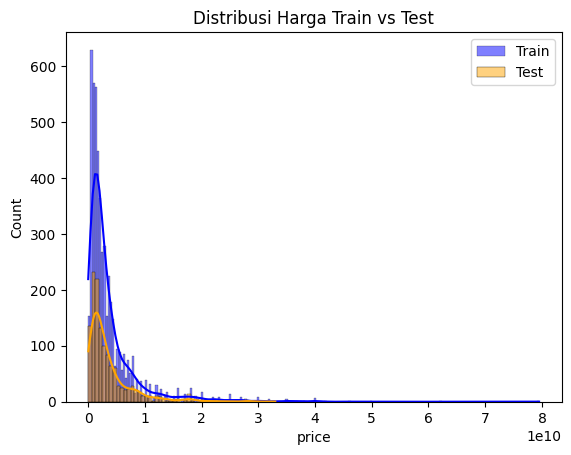

In [91]:
sns.histplot(y_train, kde=True, color='blue', label='Train')
sns.histplot(y_test, kde=True, color='orange', label='Test')
plt.legend()
plt.title("Distribusi Harga Train vs Test")
plt.show()

## Linear Regression

### Base Model

In [92]:
model = LinearRegression()

cv_mae, cv_rmse, cv_r2 = get_cv_scores(model, X_train, y_train, kf)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Cross-Validation Metrics:")
print(f"MAE  : {cv_mae:.2f}")
print(f"RMSE : {cv_rmse:.2f}")
print(f"R2   : {cv_r2:.4f}\n")

print("Test Set Metrics:")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R2   : {test_r2:.4f}")

Cross-Validation Metrics:
MAE  : 1671103611.33
RMSE : 3496460247.51
R2   : 0.5428

Test Set Metrics:
MAE  : 1541513473.09
RMSE : 2943302175.87
R2   : 0.5272


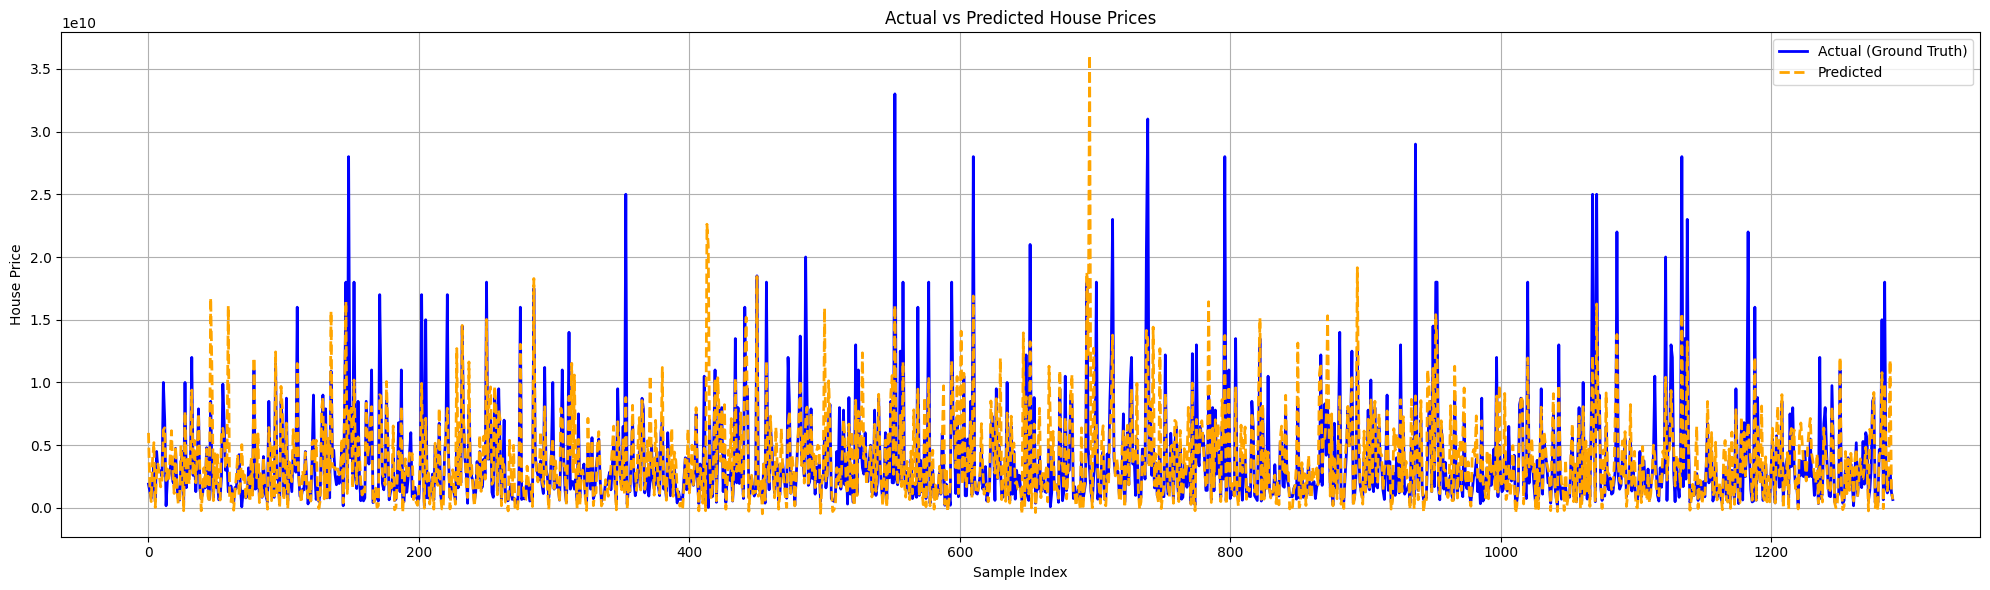

In [93]:
indices = np.arange(len(y_test))

plt.figure(figsize=(20, 6))
plt.plot(indices, y_test.values, label='Actual (Ground Truth)', color='blue', linewidth=2)
plt.plot(indices, y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### With Scaler

In [94]:
model = LinearRegression()

cv_mae, cv_rmse, cv_r2 = get_cv_scores(model, X_train_scaled, y_train, kf)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Cross-Validation Metrics:")
print(f"MAE  : {cv_mae:.2f}")
print(f"RMSE : {cv_rmse:.2f}")
print(f"R2   : {cv_r2:.4f}\n")

print("Test Set Metrics:")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R2   : {test_r2:.4f}")

Cross-Validation Metrics:
MAE  : 1671103608.91
RMSE : 3496460248.20
R2   : 0.5428

Test Set Metrics:
MAE  : 1541513479.01
RMSE : 2943302176.74
R2   : 0.5272


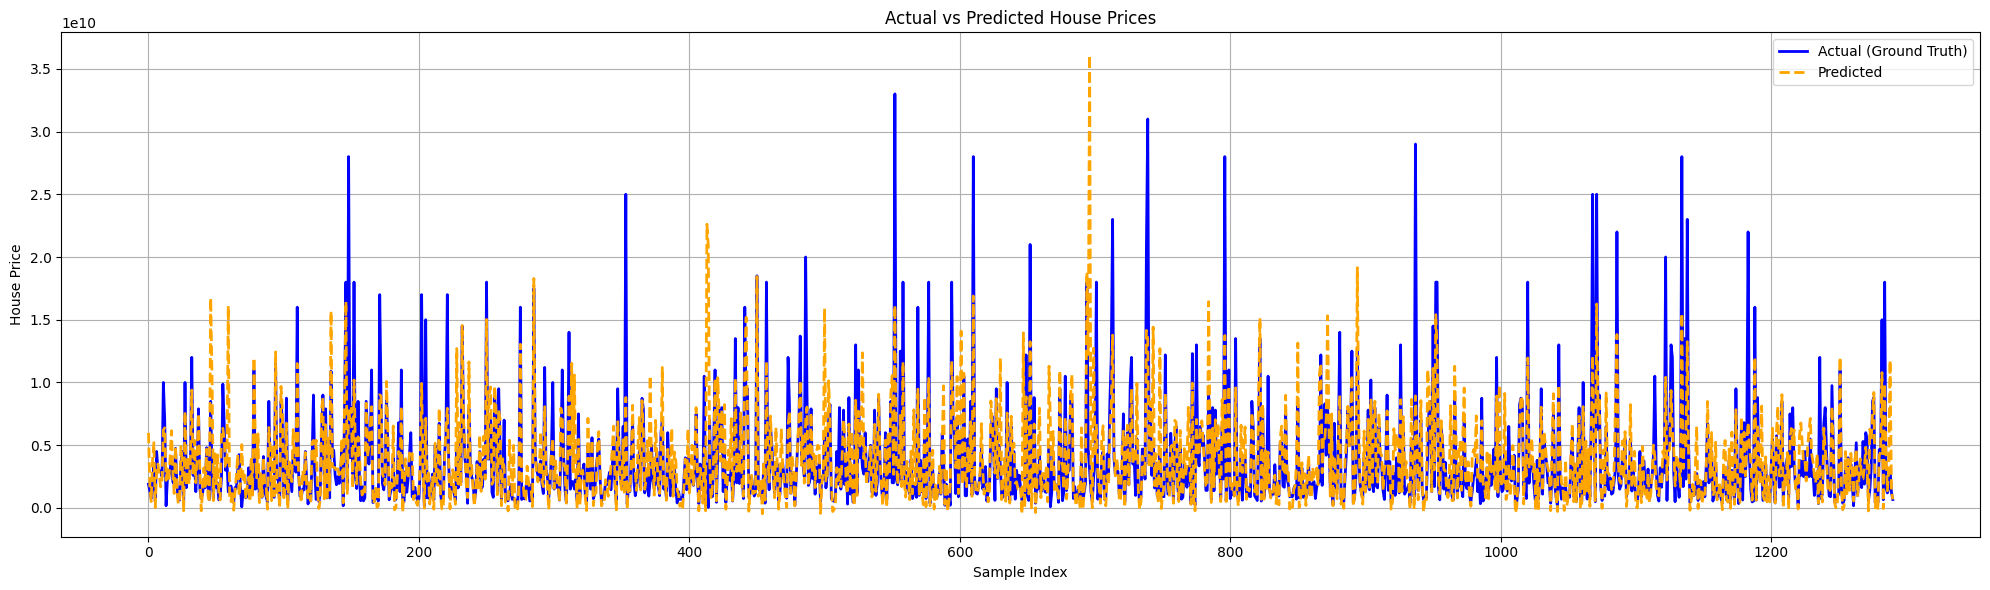

In [95]:
indices = np.arange(len(y_test))

plt.figure(figsize=(20, 6))
plt.plot(indices, y_test.values, label='Actual (Ground Truth)', color='blue', linewidth=2)
plt.plot(indices, y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### With scaler, buang Outlier

In [96]:
z_scores = np.abs(stats.zscore(X_train.select_dtypes(include=np.number)))
mask = (z_scores < 3).all(axis=1)

X_train_clean = X_train_scaled[mask]
y_train_clean = y_train[mask]

n_outliers = (~mask).sum()
total = len(mask)

print(f"Jumlah baris outlier yang dideteksi: {n_outliers}")
print(f"Persentase outlier: {n_outliers / total * 100:.2f}%")

Jumlah baris outlier yang dideteksi: 277
Persentase outlier: 5.37%


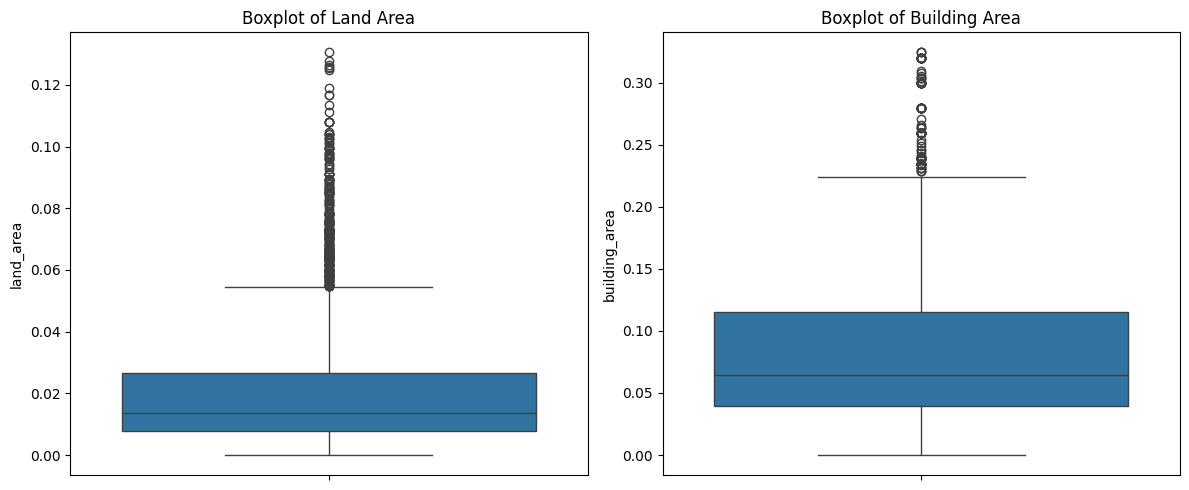

In [97]:
X_train_clean_df = pd.DataFrame(X_train_clean, columns=X_train.columns)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=X_train_clean_df['land_area'], ax=axes[0])
axes[0].set_title('Boxplot of Land Area')

sns.boxplot(y=X_train_clean_df['building_area'], ax=axes[1])
axes[1].set_title('Boxplot of Building Area')

plt.tight_layout()
plt.show()

In [98]:
model = LinearRegression()

cv_mae, cv_rmse, cv_r2 = get_cv_scores(model, X_train_clean, y_train_clean, kf)

model.fit(X_train_clean, y_train_clean)
y_pred = model.predict(X_test_scaled)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Cross-Validation Metrics:")
print(f"MAE  : {cv_mae:.2f}")
print(f"RMSE : {cv_rmse:.2f}")
print(f"R2   : {cv_r2:.4f}\n")

print("Test Set Metrics:")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R2   : {test_r2:.4f}")

Cross-Validation Metrics:
MAE  : 1372546762.07
RMSE : 2623212111.93
R2   : 0.6184

Test Set Metrics:
MAE  : 1632748576.74
RMSE : 4182154262.22
R2   : 0.0454


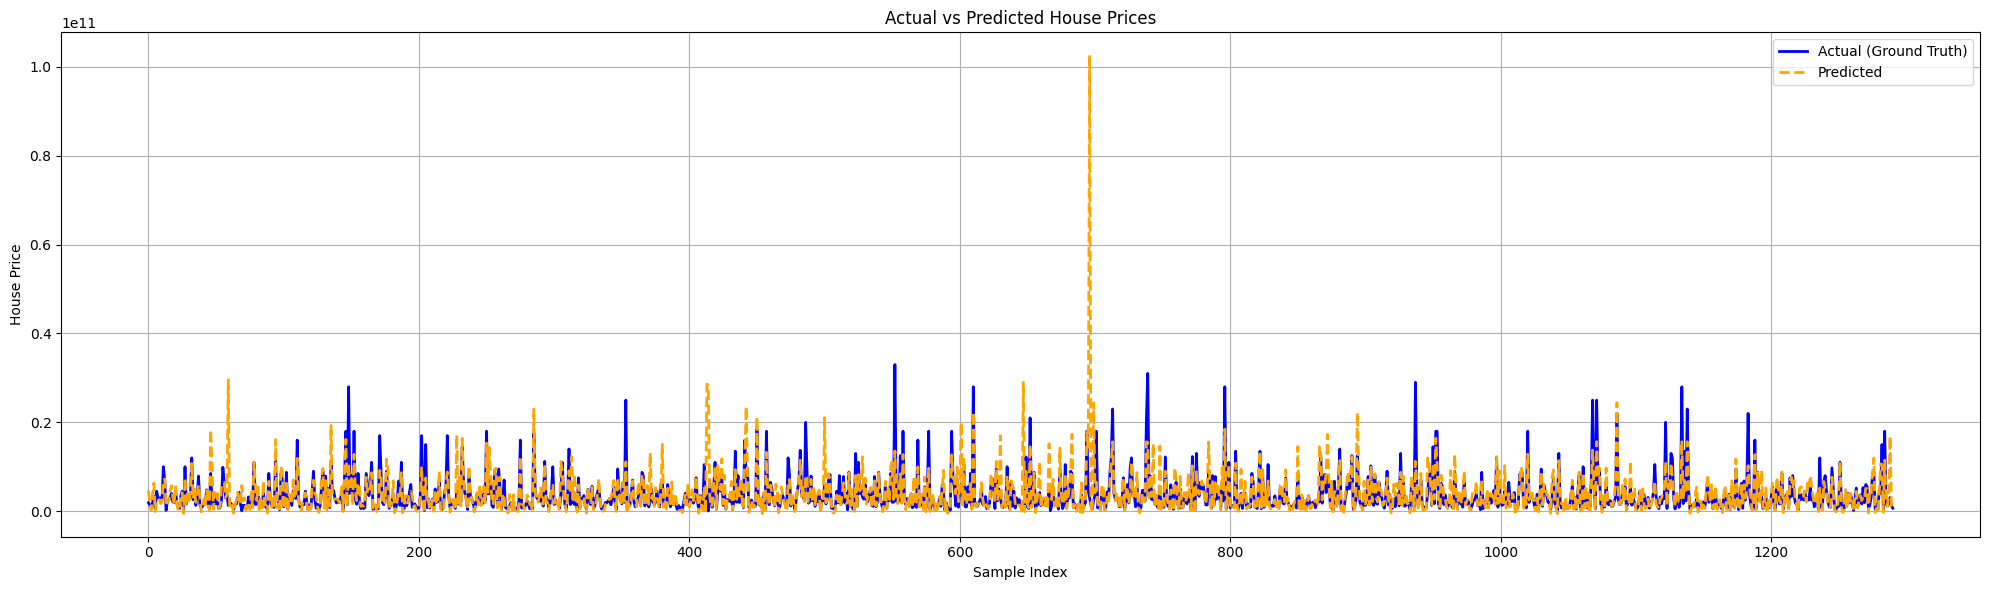

In [99]:
indices = np.arange(len(y_test))

plt.figure(figsize=(20, 6))
plt.plot(indices, y_test.values, label='Actual (Ground Truth)', color='blue', linewidth=2)
plt.plot(indices, y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Decision Tree Regressor

### Hyperparameter tuning

In [100]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 2, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", [None, "sqrt", "log2"])
    criterion = trial.suggest_categorical("criterion", ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'])

    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

    return -np.mean(scores)

In [101]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)

[I 2025-06-17 03:21:10,752] A new study created in memory with name: no-name-9abb6185-0725-4290-a0e0-92d1b8e86bb7
[I 2025-06-17 03:21:11,001] Trial 0 finished with value: 3161413297.09912 and parameters: {'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': None, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 3161413297.09912.
[I 2025-06-17 03:21:11,576] Trial 1 finished with value: 3443185428.5884414 and parameters: {'max_depth': 37, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_features': 'log2', 'criterion': 'absolute_error'}. Best is trial 0 with value: 3161413297.09912.
[I 2025-06-17 03:21:11,641] Trial 2 finished with value: 3051136142.7784653 and parameters: {'max_depth': 47, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': None, 'criterion': 'poisson'}. Best is trial 2 with value: 3051136142.7784653.
[I 2025-06-17 03:21:12,226] Trial 3 finished with value: 3443185428.5884414 and parameters: {'max_depth': 21, 'min_sa

Best RMSE: 2997202390.9068117
Best params: {'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 16, 'max_features': None, 'criterion': 'poisson'}


### with best parameters

In [102]:
best_model = DecisionTreeRegressor(**study.best_params, random_state=42)

cv_mae, cv_rmse, cv_r2 = get_cv_scores(best_model, X_train, y_train, kf)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Cross-Validation Metrics:")
print(f"MAE  : {cv_mae:.2f}")
print(f"RMSE : {cv_rmse:.2f}")
print(f"R2   : {cv_r2:.4f}\n")

print("Test Set Metrics:")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R2   : {test_r2:.4f}")

Cross-Validation Metrics:
MAE  : 1333280670.05
RMSE : 2997202390.91
R2   : 0.6639

Test Set Metrics:
MAE  : 1209891026.09
RMSE : 2614703125.40
R2   : 0.6269


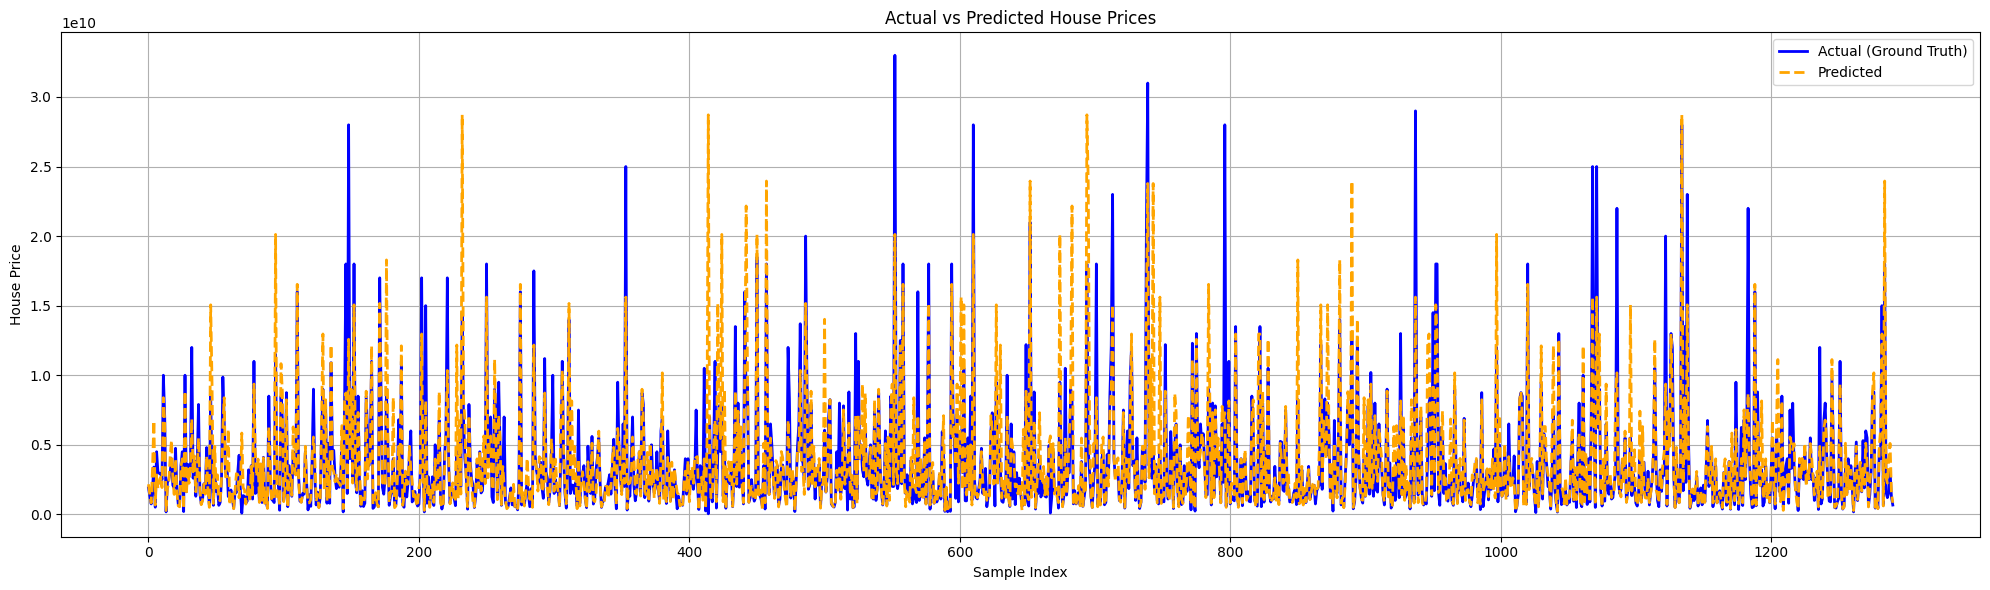

In [103]:
indices = np.arange(len(y_test))

plt.figure(figsize=(20, 6))
plt.plot(indices, y_test.values, label='Actual (Ground Truth)', color='blue', linewidth=2)
plt.plot(indices, y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### With Scaler

In [104]:
best_model = DecisionTreeRegressor(**study.best_params, random_state=42)

cv_mae, cv_rmse, cv_r2 = get_cv_scores(best_model, X_train_scaled, y_train, kf)

best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Cross-Validation Metrics:")
print(f"MAE  : {cv_mae:.2f}")
print(f"RMSE : {cv_rmse:.2f}")
print(f"R2   : {cv_r2:.4f}\n")

print("Test Set Metrics:")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R2   : {test_r2:.4f}")

Cross-Validation Metrics:
MAE  : 1333405165.17
RMSE : 2997253635.27
R2   : 0.6638

Test Set Metrics:
MAE  : 1209836804.55
RMSE : 2614697029.76
R2   : 0.6269


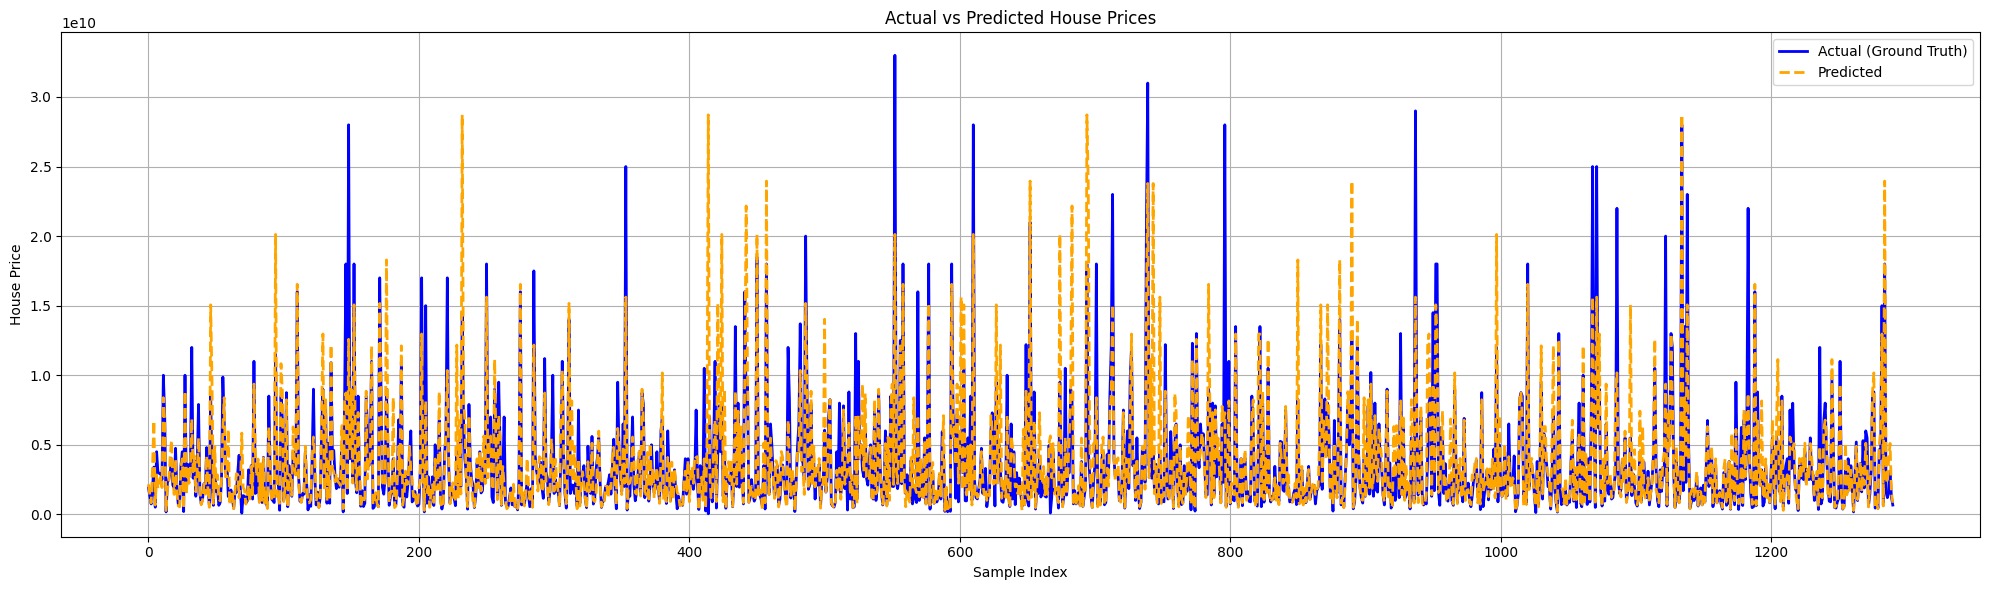

In [105]:
indices = np.arange(len(y_test))

plt.figure(figsize=(20, 6))
plt.plot(indices, y_test.values, label='Actual (Ground Truth)', color='blue', linewidth=2)
plt.plot(indices, y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### With scaler, buang outlier

In [106]:
z_scores = np.abs(stats.zscore(X_train.select_dtypes(include=np.number)))
mask = (z_scores < 3).all(axis=1)

X_train_clean = X_train_scaled[mask]
y_train_clean = y_train[mask]

n_outliers = (~mask).sum()
total = len(mask)

print(f"Jumlah baris outlier yang dideteksi: {n_outliers}")
print(f"Persentase outlier: {n_outliers / total * 100:.2f}%")

Jumlah baris outlier yang dideteksi: 277
Persentase outlier: 5.37%


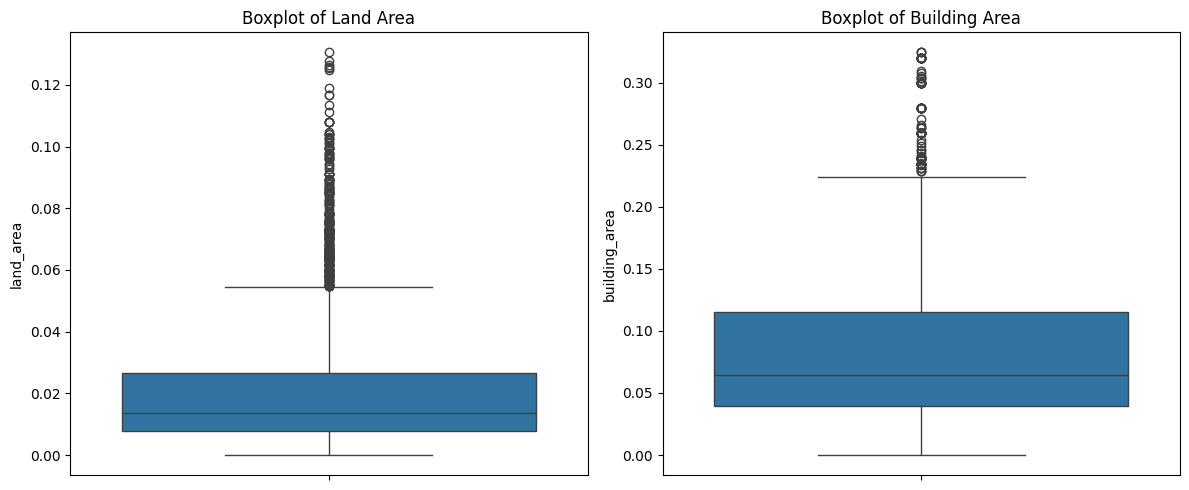

In [107]:
X_train_clean_df = pd.DataFrame(X_train_clean, columns=X_train.columns)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=X_train_clean_df['land_area'], ax=axes[0])
axes[0].set_title('Boxplot of Land Area')

sns.boxplot(y=X_train_clean_df['building_area'], ax=axes[1])
axes[1].set_title('Boxplot of Building Area')

plt.tight_layout()
plt.show()

In [108]:
best_model = DecisionTreeRegressor(**study.best_params, random_state=42)

cv_mae, cv_rmse, cv_r2 = get_cv_scores(best_model, X_train_clean, y_train_clean, kf)

best_model.fit(X_train_clean, y_train_clean)
y_pred = best_model.predict(X_test_scaled)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Cross-Validation Metrics:")
print(f"MAE  : {cv_mae:.2f}")
print(f"RMSE : {cv_rmse:.2f}")
print(f"R2   : {cv_r2:.4f}\n")

print("Test Set Metrics:")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R2   : {test_r2:.4f}")

Cross-Validation Metrics:
MAE  : 1112151526.55
RMSE : 2403835853.26
R2   : 0.6766

Test Set Metrics:
MAE  : 1205544685.42
RMSE : 2694785556.31
R2   : 0.6037


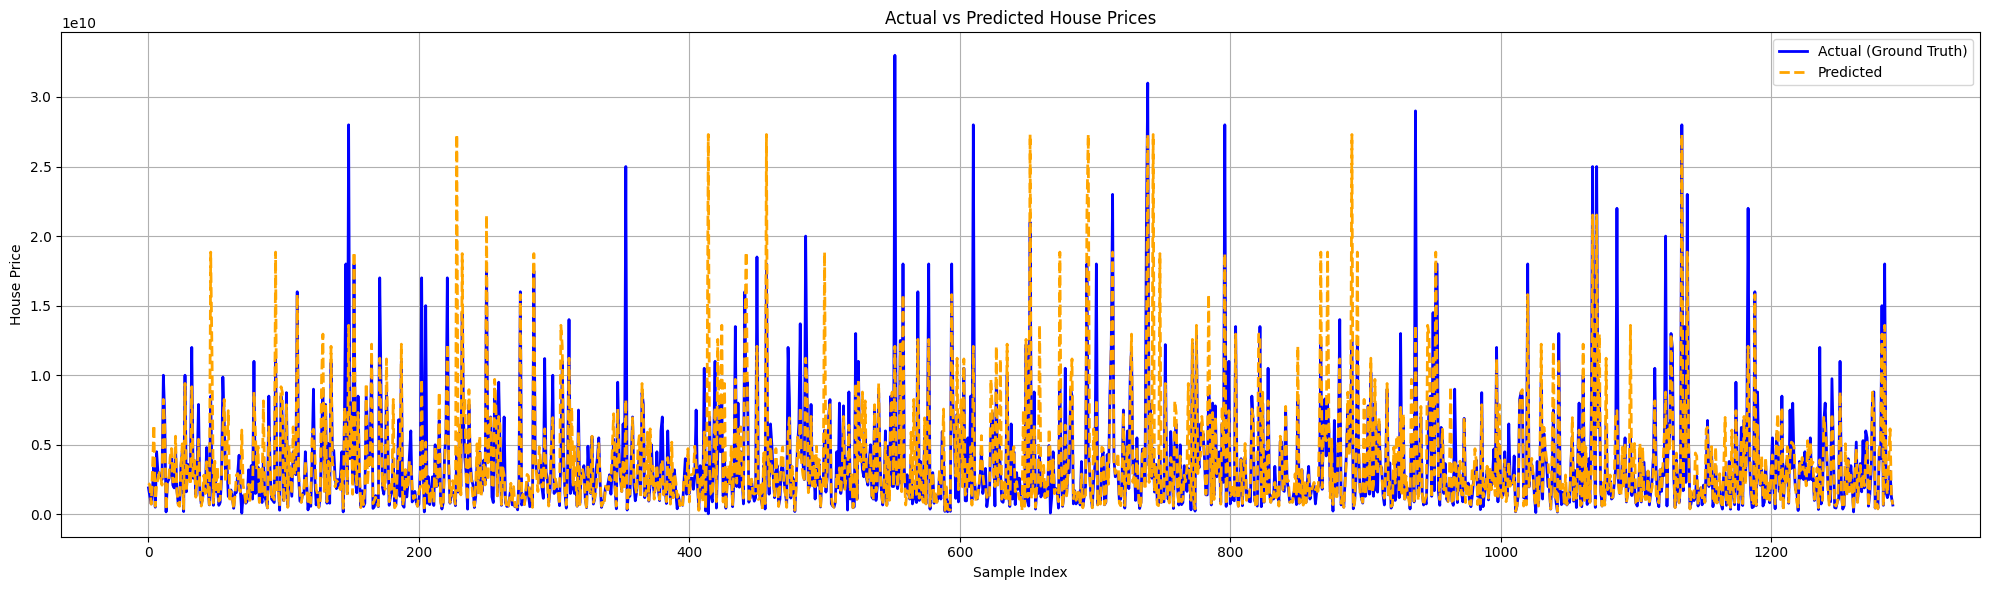

In [109]:
indices = np.arange(len(y_test))

plt.figure(figsize=(20, 6))
plt.plot(indices, y_test.values, label='Actual (Ground Truth)', color='blue', linewidth=2)
plt.plot(indices, y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Random Forest Regressor

### Hyperparameter Tuning

In [110]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 2, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    criterion = trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse", "poisson"])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        criterion=criterion,
        random_state=42,
        n_jobs=-1  # paralel
    )

    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)

    return -np.mean(scores)

In [111]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)

[I 2025-06-17 03:21:58,392] A new study created in memory with name: no-name-6054624f-f107-47bc-bcc4-4537bbd697d9
[I 2025-06-17 03:22:06,785] Trial 0 finished with value: 2940460885.120856 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 2940460885.120856.
[I 2025-06-17 03:22:20,080] Trial 1 finished with value: 2878887129.8015857 and parameters: {'n_estimators': 700, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'poisson'}. Best is trial 1 with value: 2878887129.8015857.
[I 2025-06-17 03:31:15,057] Trial 2 finished with value: 3474086497.9981384 and parameters: {'n_estimators': 500, 'max_depth': 40, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False, 'criterion': 'absolute_error'}. Best is trial 1 with value: 2878887129

Best RMSE: 2783568579.1139116
Best params: {'n_estimators': 600, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'squared_error'}


### With best parameters

In [112]:
best_model = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)

cv_mae, cv_rmse, cv_r2 = get_cv_scores(best_model, X_train, y_train, kf)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Cross-Validation Metrics:")
print(f"MAE  : {cv_mae:.2f}")
print(f"RMSE : {cv_rmse:.2f}")
print(f"R2   : {cv_r2:.4f}\n")

print("Test Set Metrics:")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R2   : {test_r2:.4f}")

Cross-Validation Metrics:
MAE  : 1130692690.56
RMSE : 2783568579.11
R2   : 0.7108

Test Set Metrics:
MAE  : 999826708.51
RMSE : 2510380720.66
R2   : 0.6561


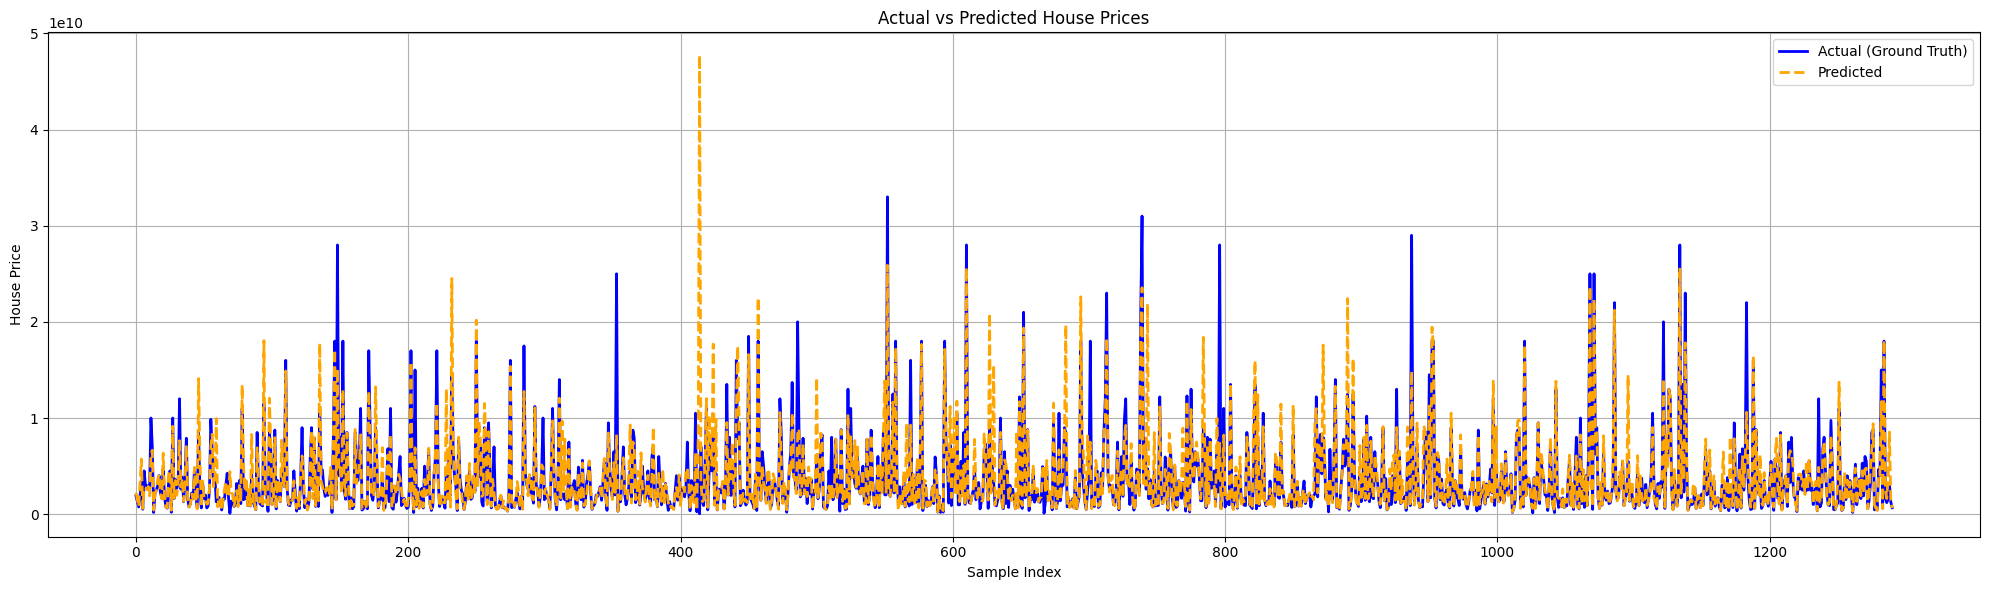

In [113]:
indices = np.arange(len(y_test))

plt.figure(figsize=(20, 6))
plt.plot(indices, y_test.values, label='Actual (Ground Truth)', color='blue', linewidth=2)
plt.plot(indices, y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### With Scaler

In [114]:
best_model = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)

cv_mae, cv_rmse, cv_r2 = get_cv_scores(best_model, X_train_scaled, y_train, kf)

best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Cross-Validation Metrics:")
print(f"MAE  : {cv_mae:.2f}")
print(f"RMSE : {cv_rmse:.2f}")
print(f"R2   : {cv_r2:.4f}\n")

print("Test Set Metrics:")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R2   : {test_r2:.4f}")

Cross-Validation Metrics:
MAE  : 1130770659.73
RMSE : 2782762069.09
R2   : 0.7110

Test Set Metrics:
MAE  : 1000226467.67
RMSE : 2511810011.76
R2   : 0.6557


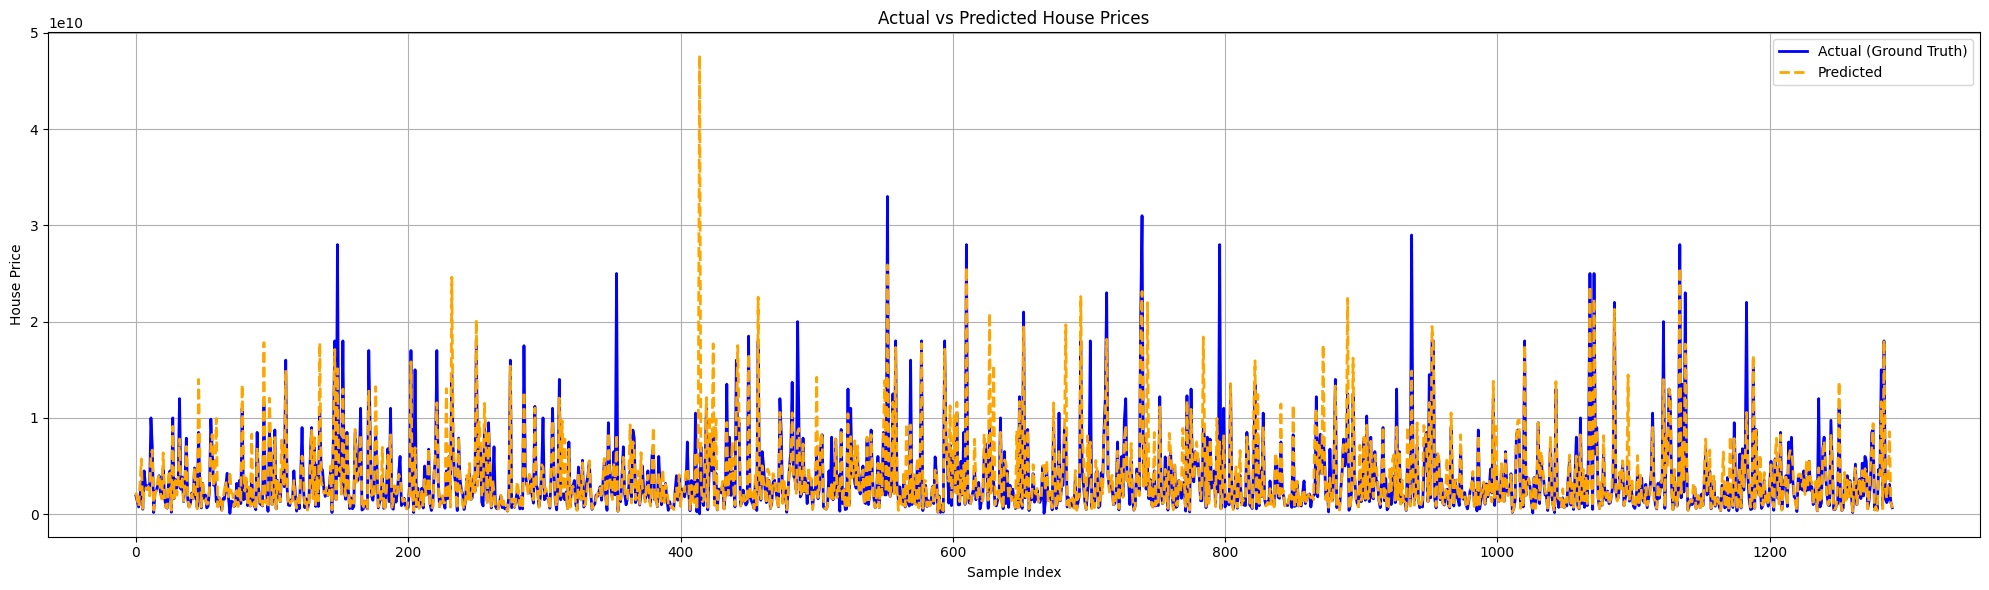

In [115]:
indices = np.arange(len(y_test))

plt.figure(figsize=(20, 6))
plt.plot(indices, y_test.values, label='Actual (Ground Truth)', color='blue', linewidth=2)
plt.plot(indices, y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### with scaler, buang outlier

In [116]:
z_scores = np.abs(stats.zscore(X_train.select_dtypes(include=np.number)))
mask = (z_scores < 3).all(axis=1)

X_train_clean = X_train_scaled[mask]
y_train_clean = y_train[mask]

n_outliers = (~mask).sum()
total = len(mask)

print(f"Jumlah baris outlier yang dideteksi: {n_outliers}")
print(f"Persentase outlier: {n_outliers / total * 100:.2f}%")

Jumlah baris outlier yang dideteksi: 277
Persentase outlier: 5.37%


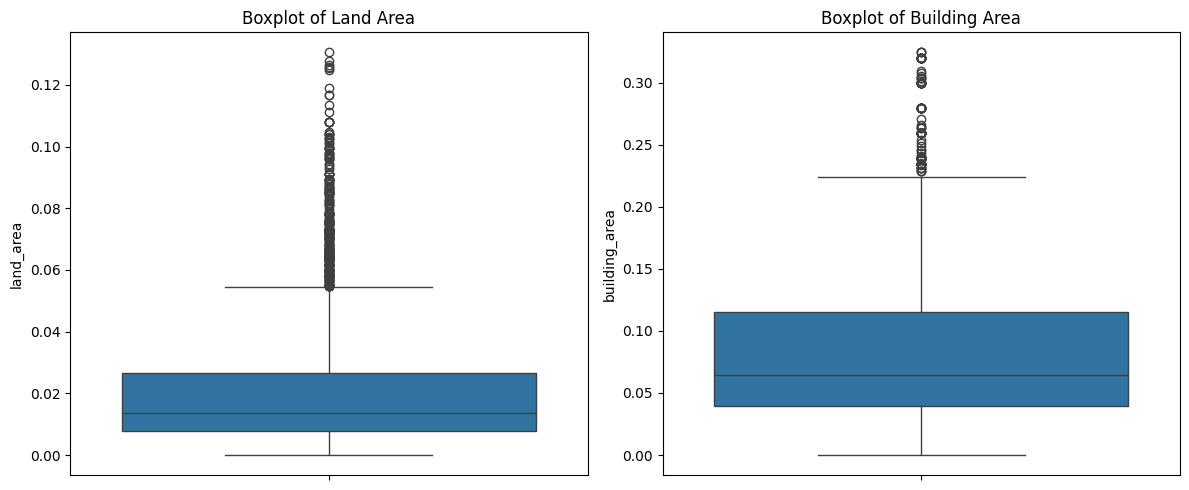

In [117]:
X_train_clean_df = pd.DataFrame(X_train_clean, columns=X_train.columns)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=X_train_clean_df['land_area'], ax=axes[0])
axes[0].set_title('Boxplot of Land Area')

sns.boxplot(y=X_train_clean_df['building_area'], ax=axes[1])
axes[1].set_title('Boxplot of Building Area')

plt.tight_layout()
plt.show()

In [118]:
best_model = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)

cv_mae, cv_rmse, cv_r2 = get_cv_scores(best_model, X_train_clean, y_train_clean, kf)

best_model.fit(X_train_clean, y_train_clean)
y_pred = best_model.predict(X_test_scaled)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Cross-Validation Metrics:")
print(f"MAE  : {cv_mae:.2f}")
print(f"RMSE : {cv_rmse:.2f}")
print(f"R2   : {cv_r2:.4f}\n")

print("Test Set Metrics:")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R2   : {test_r2:.4f}")

Cross-Validation Metrics:
MAE  : 913276892.22
RMSE : 2136695947.43
R2   : 0.7449

Test Set Metrics:
MAE  : 1043166735.61
RMSE : 2494403723.68
R2   : 0.6604


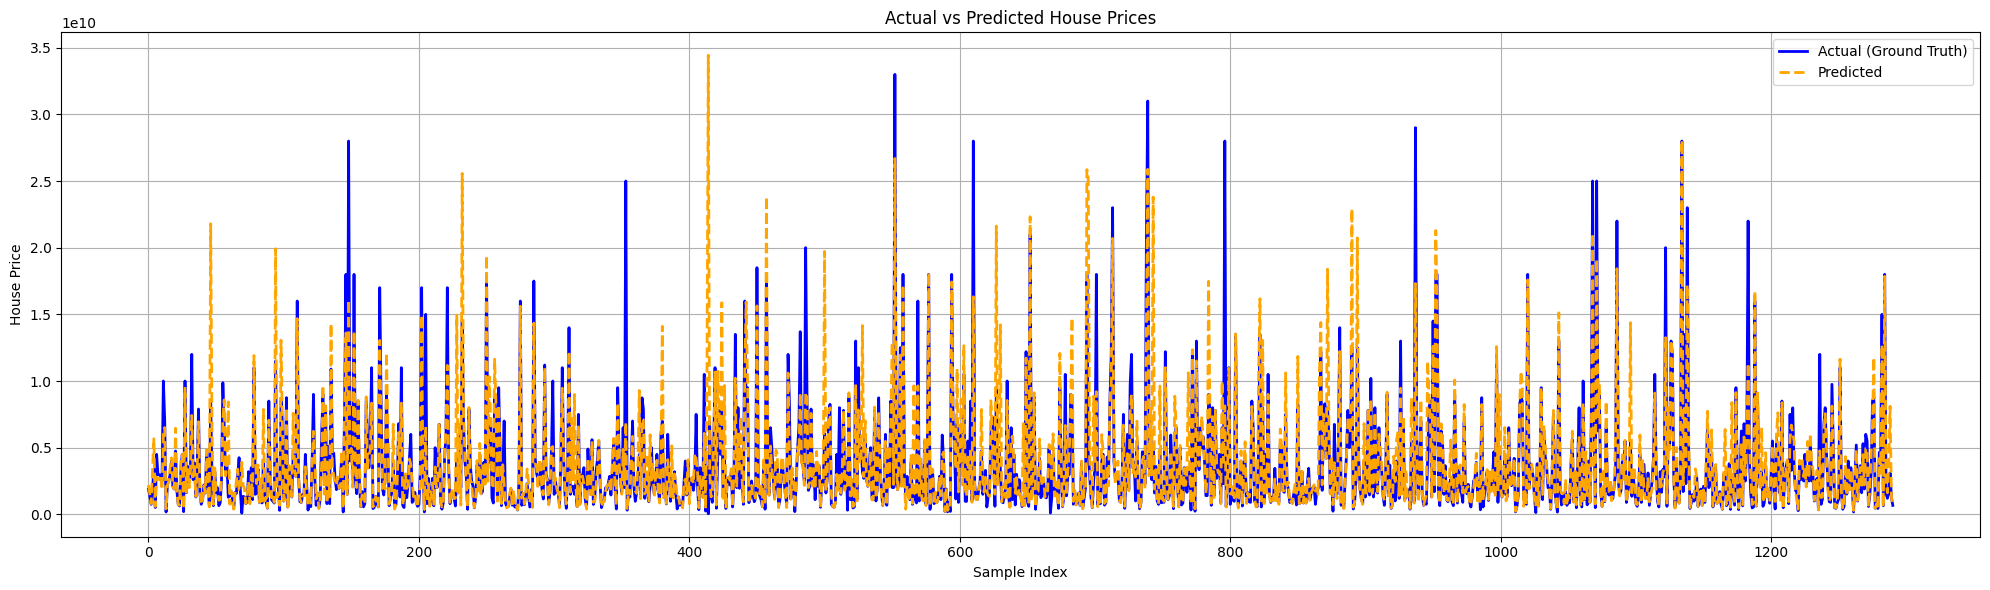

In [119]:
indices = np.arange(len(y_test))

plt.figure(figsize=(20, 6))
plt.plot(indices, y_test.values, label='Actual (Ground Truth)', color='blue', linewidth=2)
plt.plot(indices, y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## XGBoost Regressor (Gradient Boosting)

### Hyperparameter Tuning

In [120]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "random_state": 42,
        "n_jobs": -1,
        "tree_method": "hist",  # lebih cepat
    }

    model = XGBRegressor(**param)

    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)

    return -np.mean(scores)

In [121]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)

[I 2025-06-17 04:11:10,580] A new study created in memory with name: no-name-cad2aa19-60bf-4c5d-8139-f85d9934b174
[I 2025-06-17 04:11:21,460] Trial 0 finished with value: 2889167110.467777 and parameters: {'n_estimators': 800, 'max_depth': 15, 'learning_rate': 0.1190084766545031, 'subsample': 0.9956212728236491, 'colsample_bytree': 0.9670001841350666, 'min_child_weight': 3, 'gamma': 3.7296060737104977, 'reg_alpha': 5.02823249727739, 'reg_lambda': 8.101682952679754}. Best is trial 0 with value: 2889167110.467777.
[I 2025-06-17 04:11:24,716] Trial 1 finished with value: 2976205427.7053304 and parameters: {'n_estimators': 800, 'max_depth': 11, 'learning_rate': 0.04956538503642076, 'subsample': 0.9942653565578495, 'colsample_bytree': 0.936230502638355, 'min_child_weight': 9, 'gamma': 3.807833391886588, 'reg_alpha': 1.4542409396940736, 'reg_lambda': 3.8054938611003575}. Best is trial 0 with value: 2889167110.467777.
[I 2025-06-17 04:11:25,160] Trial 2 finished with value: 4243883350.2163897

Best RMSE: 2789652011.327607
Best params: {'n_estimators': 1000, 'max_depth': 15, 'learning_rate': 0.0035924660731297894, 'subsample': 0.8322288990426941, 'colsample_bytree': 0.8816714316111716, 'min_child_weight': 4, 'gamma': 8.665124272099087, 'reg_alpha': 9.980313002398312, 'reg_lambda': 0.7187922425549057}


### With best parameters

In [122]:
best_model = XGBRegressor(**study.best_params)

cv_mae, cv_rmse, cv_r2 = get_cv_scores(best_model, X_train, y_train, kf)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Cross-Validation Metrics:")
print(f"MAE  : {cv_mae:.2f}")
print(f"RMSE : {cv_rmse:.2f}")
print(f"R2   : {cv_r2:.4f}\n")

print("Test Set Metrics:")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R2   : {test_r2:.4f}")

Cross-Validation Metrics:
MAE  : 1141005241.67
RMSE : 2801860650.34
R2   : 0.7069

Test Set Metrics:
MAE  : 1022383623.86
RMSE : 2334140273.17
R2   : 0.7027


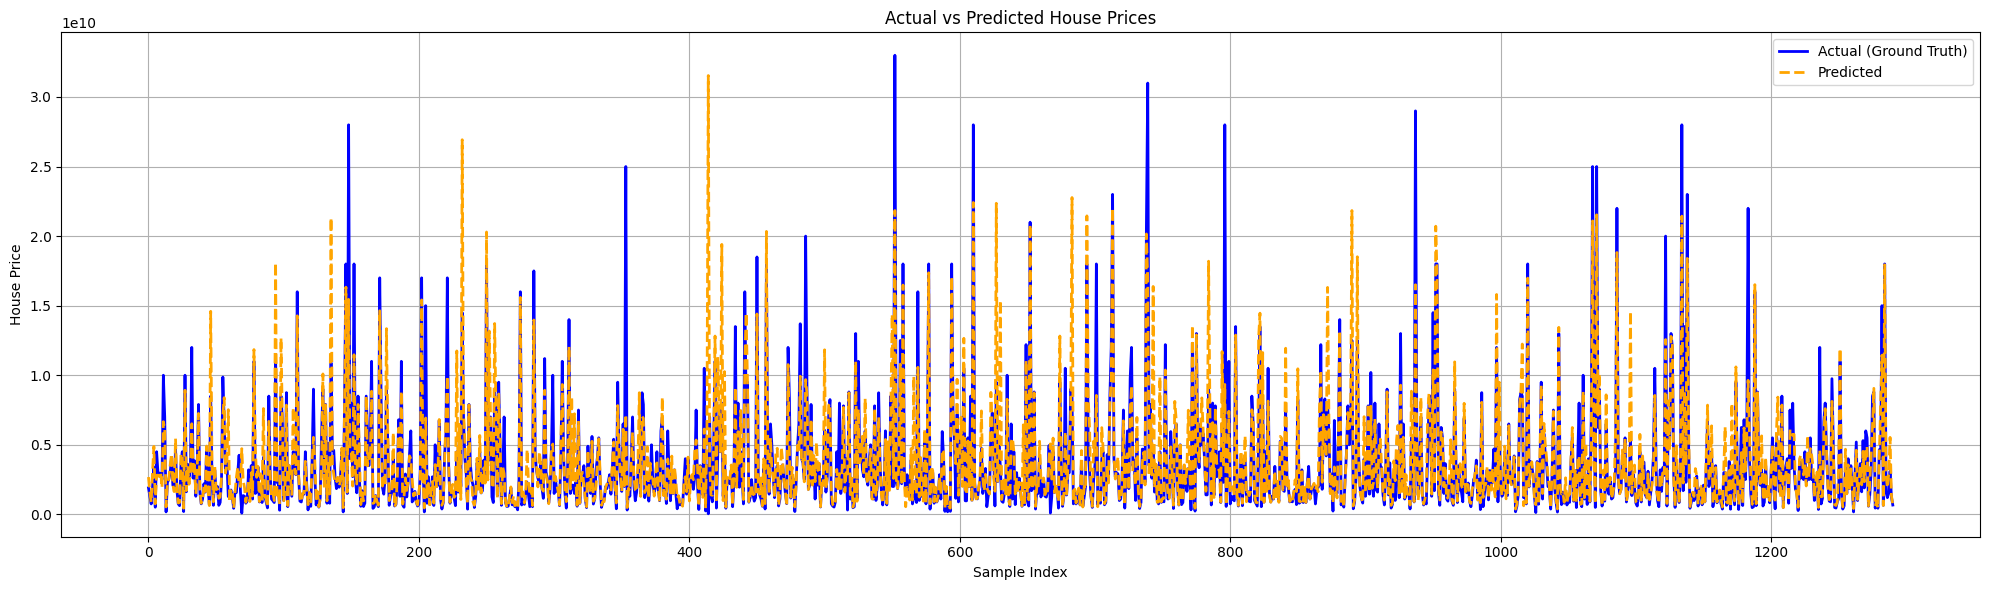

In [123]:
indices = np.arange(len(y_test))

plt.figure(figsize=(20, 6))
plt.plot(indices, y_test.values, label='Actual (Ground Truth)', color='blue', linewidth=2)
plt.plot(indices, y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### with scaler

In [124]:
best_model = XGBRegressor(**study.best_params)

cv_mae, cv_rmse, cv_r2 = get_cv_scores(best_model, X_train_scaled, y_train, kf)

best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Cross-Validation Metrics:")
print(f"MAE  : {cv_mae:.2f}")
print(f"RMSE : {cv_rmse:.2f}")
print(f"R2   : {cv_r2:.4f}\n")

print("Test Set Metrics:")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R2   : {test_r2:.4f}")

Cross-Validation Metrics:
MAE  : 1141005241.67
RMSE : 2801860650.34
R2   : 0.7069

Test Set Metrics:
MAE  : 1022383623.86
RMSE : 2334140273.17
R2   : 0.7027


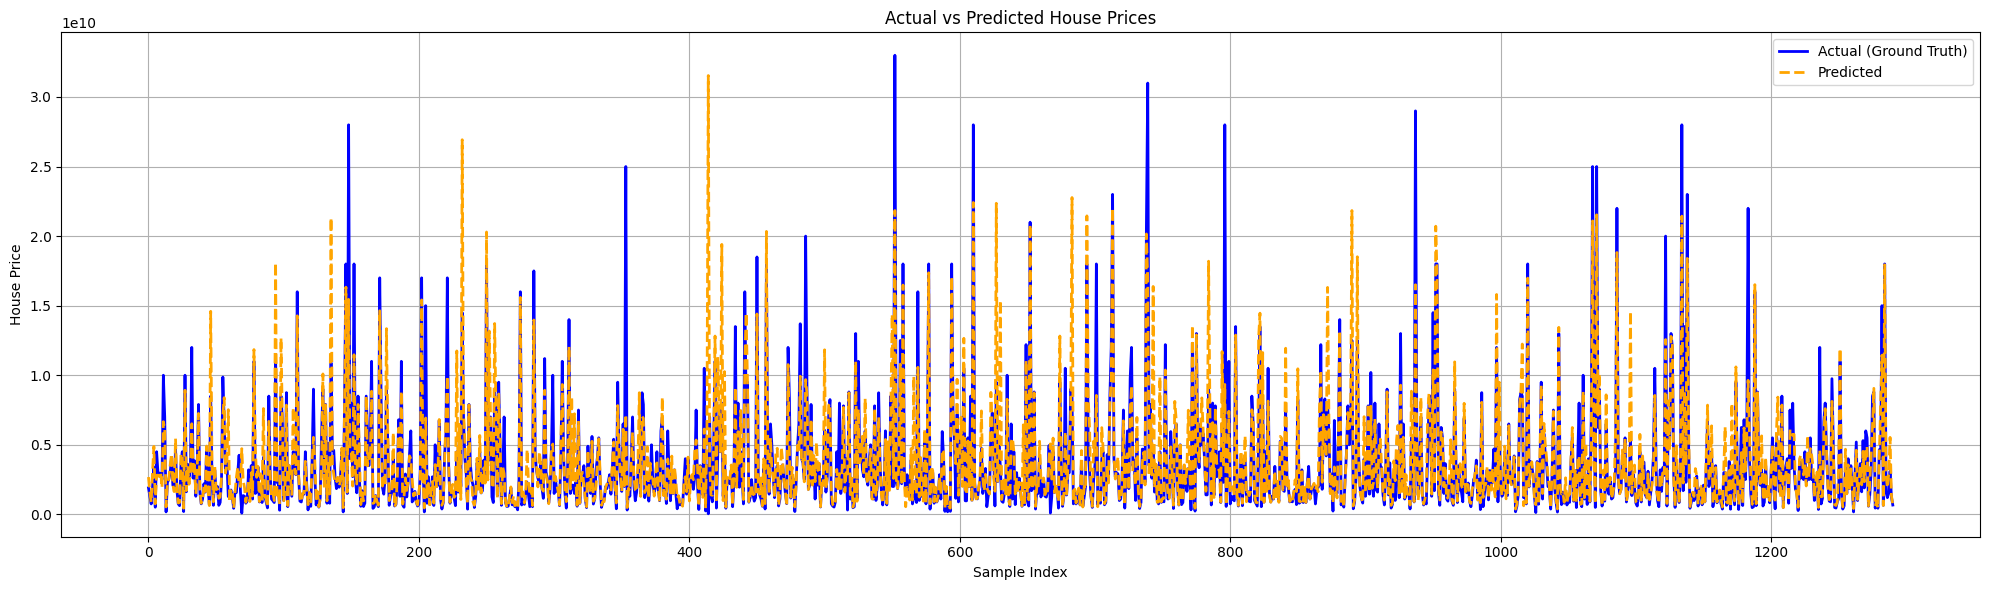

In [125]:
indices = np.arange(len(y_test))

plt.figure(figsize=(20, 6))
plt.plot(indices, y_test.values, label='Actual (Ground Truth)', color='blue', linewidth=2)
plt.plot(indices, y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### with scaler, buang outlier

In [126]:
z_scores = np.abs(stats.zscore(X_train.select_dtypes(include=np.number)))
mask = (z_scores < 3).all(axis=1)

X_train_clean = X_train_scaled[mask]
y_train_clean = y_train[mask]

n_outliers = (~mask).sum()
total = len(mask)

print(f"Jumlah baris outlier yang dideteksi: {n_outliers}")
print(f"Persentase outlier: {n_outliers / total * 100:.2f}%")

Jumlah baris outlier yang dideteksi: 277
Persentase outlier: 5.37%


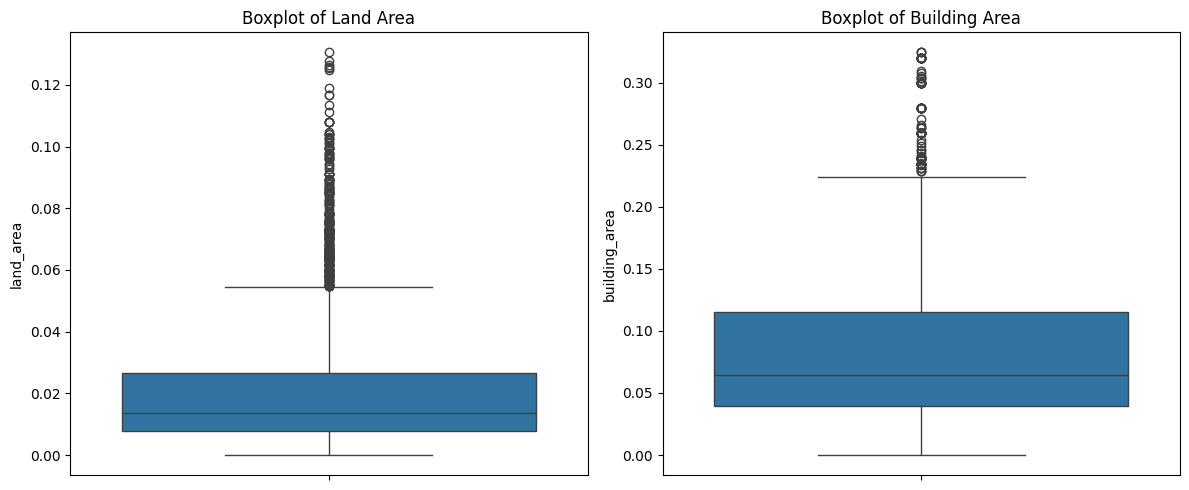

In [127]:
X_train_clean_df = pd.DataFrame(X_train_clean, columns=X_train.columns)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=X_train_clean_df['land_area'], ax=axes[0])
axes[0].set_title('Boxplot of Land Area')

sns.boxplot(y=X_train_clean_df['building_area'], ax=axes[1])
axes[1].set_title('Boxplot of Building Area')

plt.tight_layout()
plt.show()

In [128]:
best_model = XGBRegressor(**study.best_params)

cv_mae, cv_rmse, cv_r2 = get_cv_scores(best_model, X_train_clean, y_train_clean, kf)

best_model.fit(X_train_clean, y_train_clean)
y_pred = best_model.predict(X_test_scaled)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Cross-Validation Metrics:")
print(f"MAE  : {cv_mae:.2f}")
print(f"RMSE : {cv_rmse:.2f}")
print(f"R2   : {cv_r2:.4f}\n")

print("Test Set Metrics:")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R2   : {test_r2:.4f}")

Cross-Validation Metrics:
MAE  : 935629451.30
RMSE : 2191455971.72
R2   : 0.7309

Test Set Metrics:
MAE  : 1045984969.17
RMSE : 2496525990.96
R2   : 0.6598


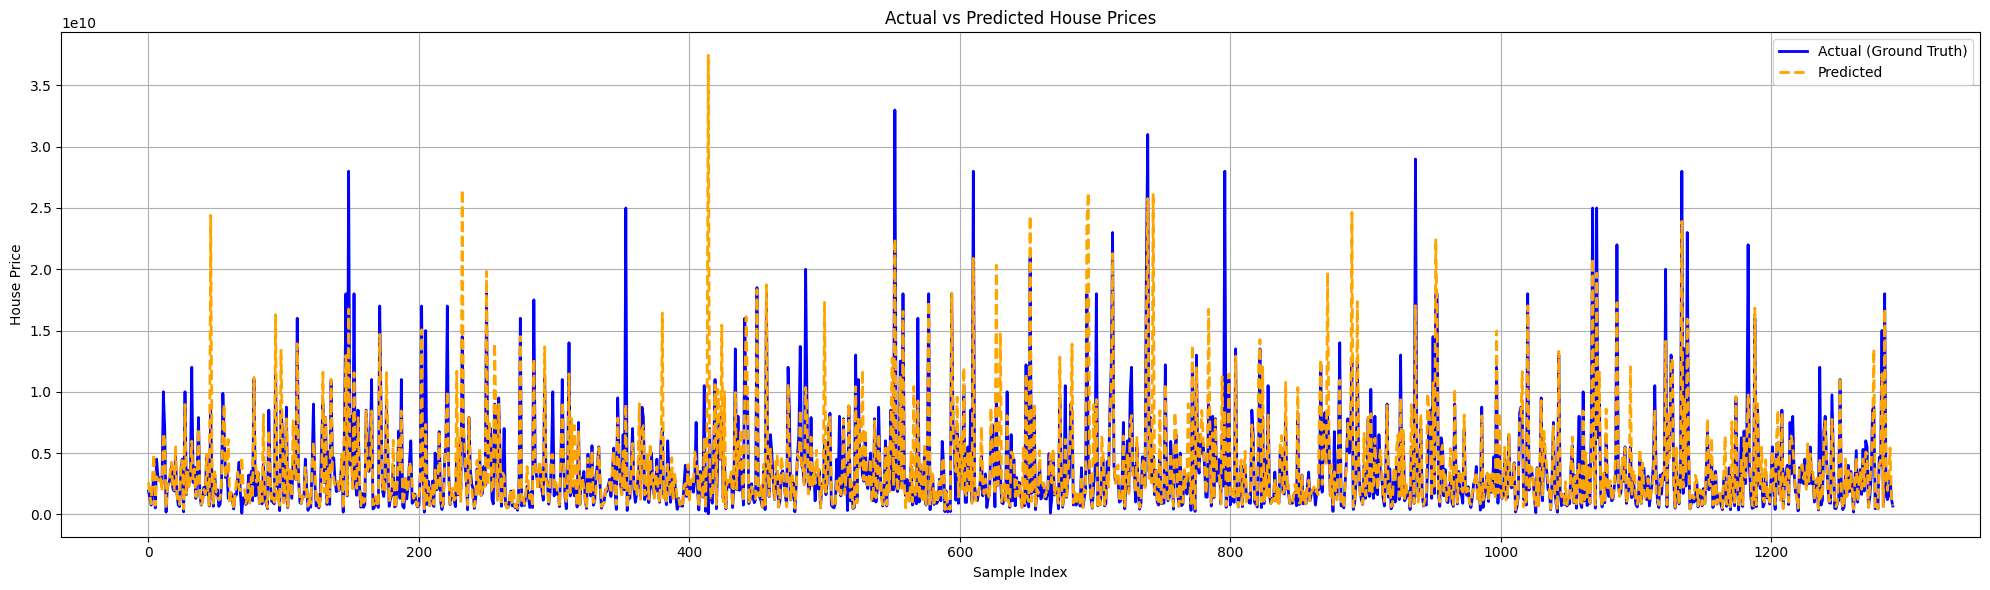

In [129]:
indices = np.arange(len(y_test))

plt.figure(figsize=(20, 6))
plt.plot(indices, y_test.values, label='Actual (Ground Truth)', color='blue', linewidth=2)
plt.plot(indices, y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## k-Nearest Neighbors Regressor

### Hyperparameter Tuning

In [130]:
def objective(trial):
    param = {
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 50),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "p": trial.suggest_int("p", 1, 2),
        "leaf_size": trial.suggest_int("leaf_size", 10, 100),
    }

    model = KNeighborsRegressor(**param)

    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_root_mean_squared_error")

    return -np.mean(scores)

In [131]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best RMSE:", study.best_value)
print("Best parameters:", study.best_params)

[I 2025-06-17 04:22:16,687] A new study created in memory with name: no-name-e739d6b9-1beb-4038-b11d-9943fdab40ae
[I 2025-06-17 04:22:16,769] Trial 0 finished with value: 3317137089.919184 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'p': 2, 'leaf_size': 31}. Best is trial 0 with value: 3317137089.919184.
[I 2025-06-17 04:22:16,823] Trial 1 finished with value: 3960411127.102678 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'p': 1, 'leaf_size': 82}. Best is trial 0 with value: 3317137089.919184.
[I 2025-06-17 04:22:16,878] Trial 2 finished with value: 3431965843.0073 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 2, 'leaf_size': 62}. Best is trial 0 with value: 3317137089.919184.
[I 2025-06-17 04:22:16,948] Trial 3 finished with value: 3285965032.707542 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'p': 2, 'leaf_size': 14}. Best is trial 3 with value: 3285965032.707542.
[I 2025-06-17 04:22:17,033] Trial 4 finished with value: 333163864

Best RMSE: 2970191218.149553
Best parameters: {'n_neighbors': 16, 'weights': 'distance', 'p': 1, 'leaf_size': 39}


### With best parameters

In [132]:
best_model = KNeighborsRegressor(**study.best_params)

cv_mae, cv_rmse, cv_r2 = get_cv_scores(best_model, X_train, y_train, kf)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Cross-Validation Metrics:")
print(f"MAE  : {cv_mae:.2f}")
print(f"RMSE : {cv_rmse:.2f}")
print(f"R2   : {cv_r2:.4f}\n")

print("Test Set Metrics:")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R2   : {test_r2:.4f}")

Cross-Validation Metrics:
MAE  : 1068215771.32
RMSE : 2970191218.15
R2   : 0.6696

Test Set Metrics:
MAE  : 1005345034.44
RMSE : 3070544232.63
R2   : 0.4854


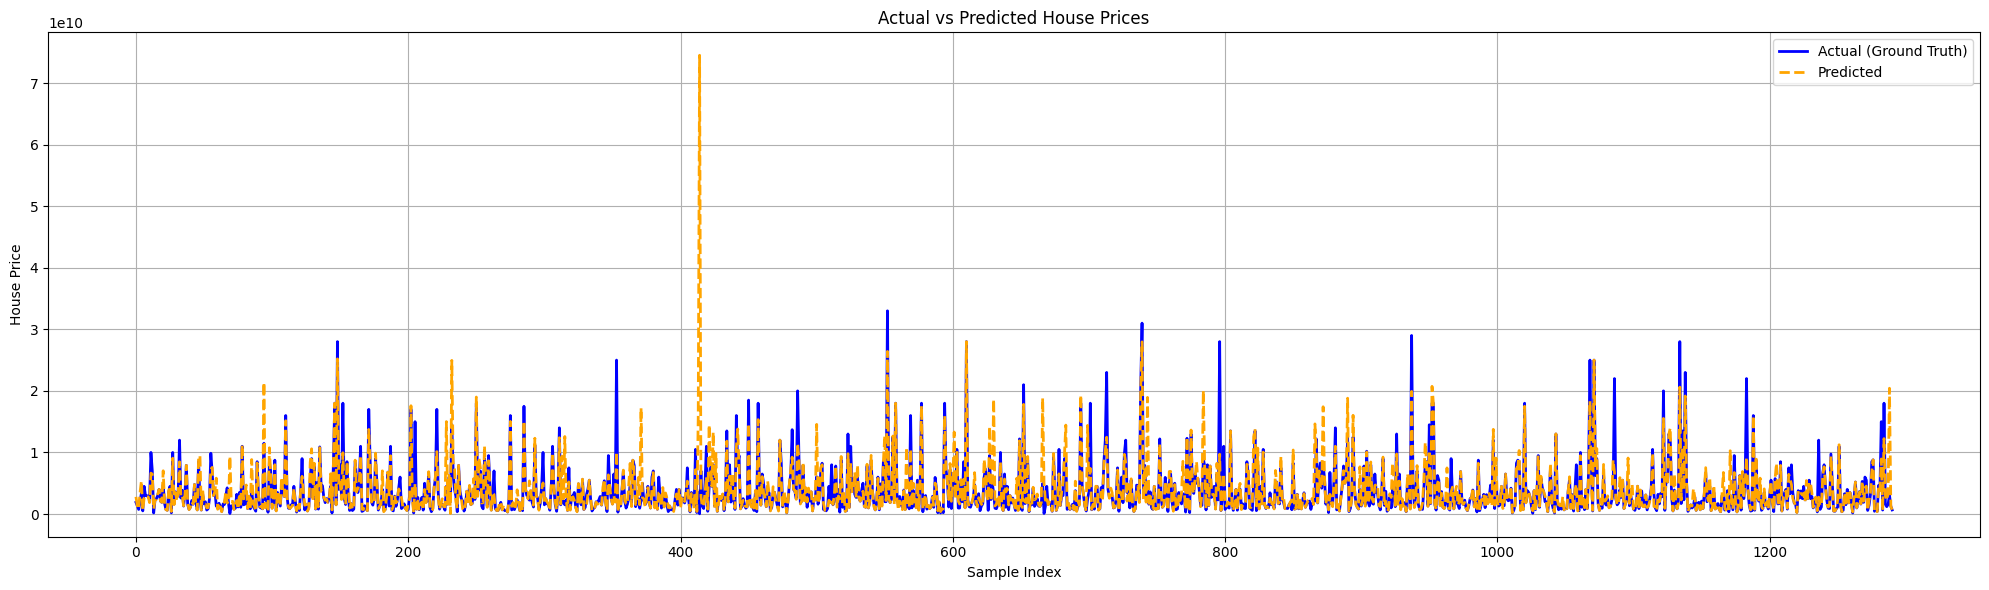

In [133]:
indices = np.arange(len(y_test))

plt.figure(figsize=(20, 6))
plt.plot(indices, y_test.values, label='Actual (Ground Truth)', color='blue', linewidth=2)
plt.plot(indices, y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### with scaler

In [134]:
best_model = KNeighborsRegressor(**study.best_params)

cv_mae, cv_rmse, cv_r2 = get_cv_scores(best_model, X_train_scaled, y_train, kf)

best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Cross-Validation Metrics:")
print(f"MAE  : {cv_mae:.2f}")
print(f"RMSE : {cv_rmse:.2f}")
print(f"R2   : {cv_r2:.4f}\n")

print("Test Set Metrics:")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R2   : {test_r2:.4f}")

Cross-Validation Metrics:
MAE  : 1238325310.84
RMSE : 3066220059.11
R2   : 0.6488

Test Set Metrics:
MAE  : 1091233276.30
RMSE : 2605610427.76
R2   : 0.6295


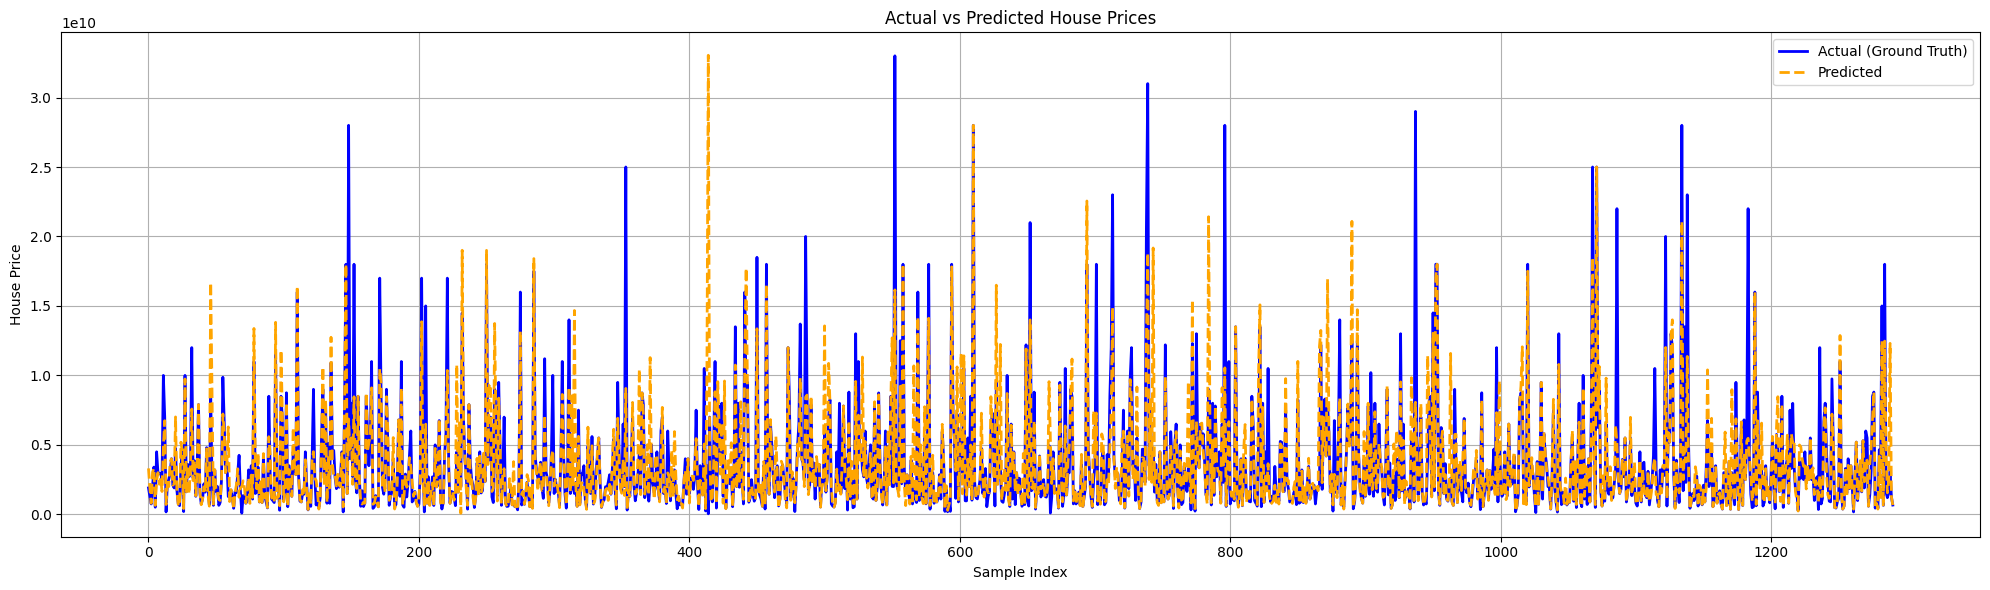

In [135]:
indices = np.arange(len(y_test))

plt.figure(figsize=(20, 6))
plt.plot(indices, y_test.values, label='Actual (Ground Truth)', color='blue', linewidth=2)
plt.plot(indices, y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### with scaler, buang outlier

In [136]:
z_scores = np.abs(stats.zscore(X_train.select_dtypes(include=np.number)))
mask = (z_scores < 3).all(axis=1)

X_train_clean = X_train_scaled[mask]
y_train_clean = y_train[mask]

n_outliers = (~mask).sum()
total = len(mask)

print(f"Jumlah baris outlier yang dideteksi: {n_outliers}")
print(f"Persentase outlier: {n_outliers / total * 100:.2f}%")

Jumlah baris outlier yang dideteksi: 277
Persentase outlier: 5.37%


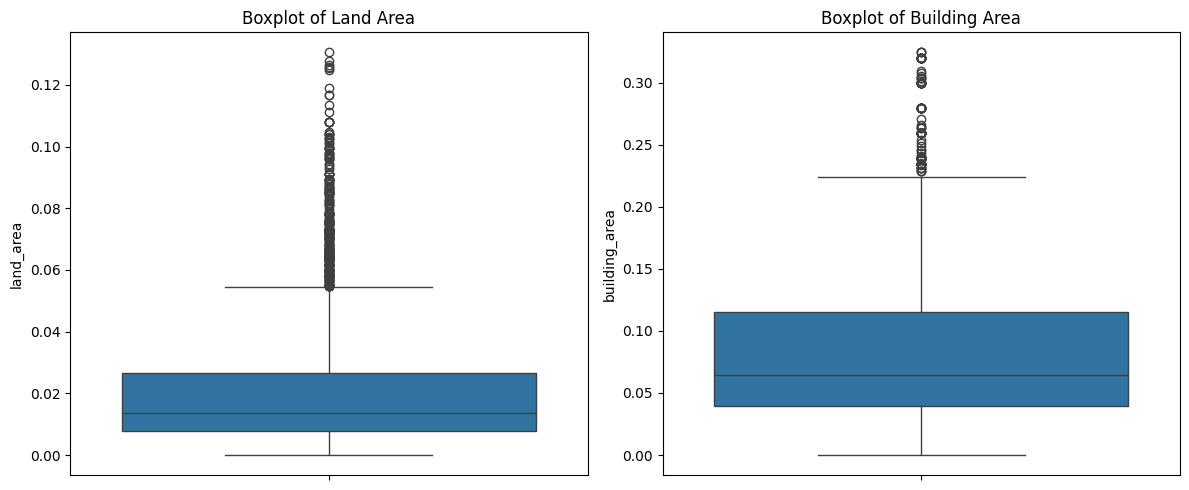

In [137]:
X_train_clean_df = pd.DataFrame(X_train_clean, columns=X_train.columns)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=X_train_clean_df['land_area'], ax=axes[0])
axes[0].set_title('Boxplot of Land Area')

sns.boxplot(y=X_train_clean_df['building_area'], ax=axes[1])
axes[1].set_title('Boxplot of Building Area')

plt.tight_layout()
plt.show()

In [138]:
best_model = KNeighborsRegressor(**study.best_params)

cv_mae, cv_rmse, cv_r2 = get_cv_scores(best_model, X_train_clean, y_train_clean, kf)

best_model.fit(X_train_clean, y_train_clean)
y_pred = best_model.predict(X_test_scaled)

test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print("Cross-Validation Metrics:")
print(f"MAE  : {cv_mae:.2f}")
print(f"RMSE : {cv_rmse:.2f}")
print(f"R2   : {cv_r2:.4f}\n")

print("Test Set Metrics:")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"R2   : {test_r2:.4f}")

Cross-Validation Metrics:
MAE  : 1018035437.30
RMSE : 2400909526.49
R2   : 0.6803

Test Set Metrics:
MAE  : 1137102002.46
RMSE : 2701064924.28
R2   : 0.6018


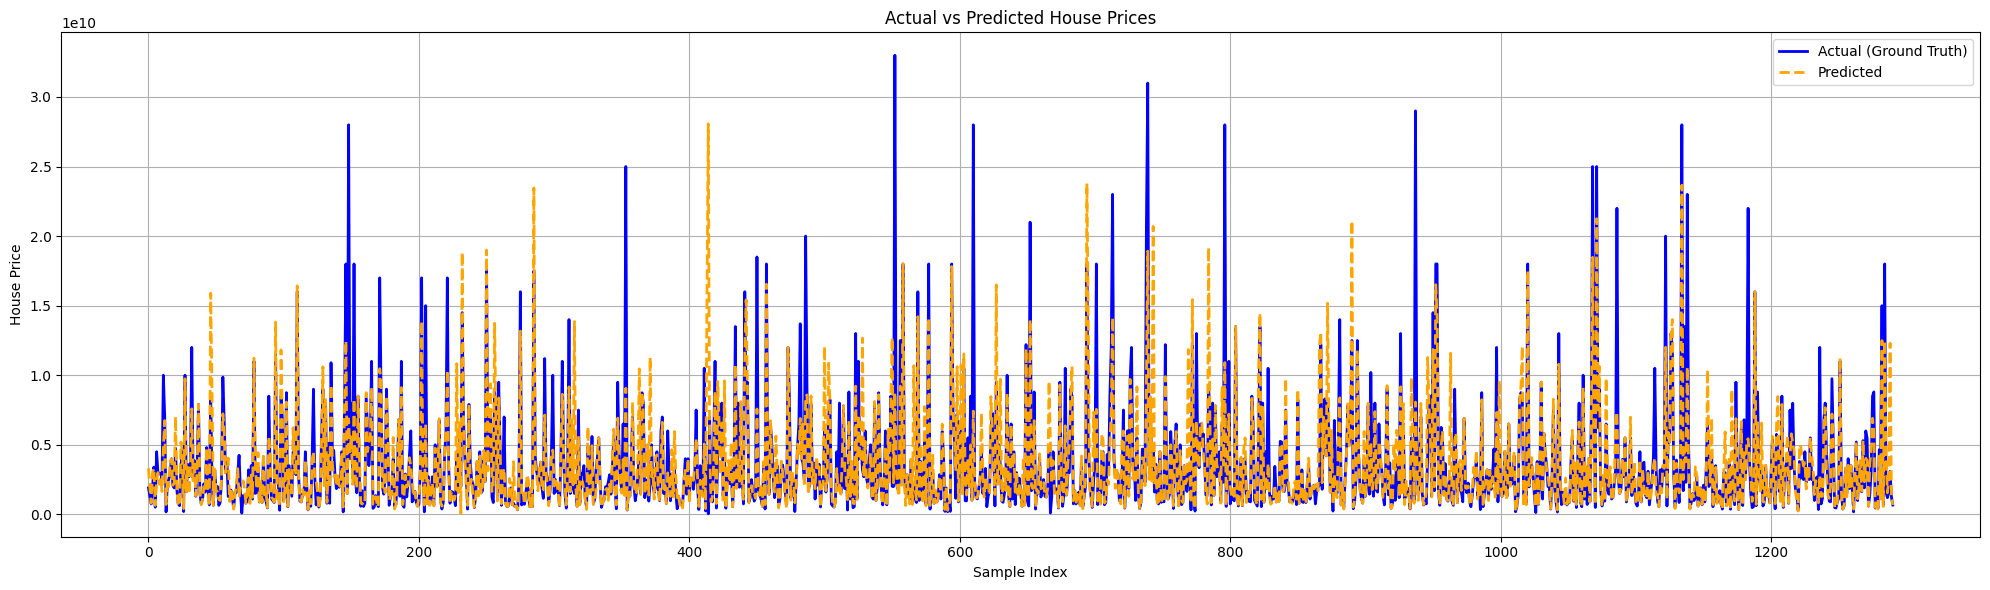

In [139]:
indices = np.arange(len(y_test))

plt.figure(figsize=(20, 6))
plt.plot(indices, y_test.values, label='Actual (Ground Truth)', color='blue', linewidth=2)
plt.plot(indices, y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Sample Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()